In [9]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import skimage.io as io
import random
from torch_geometric.data import Data

In [10]:
torch.cuda.is_available()

True

In [11]:
import numpy as np

def extract_patches(image, cell_coords, patch_size=100):
    """
    Extract image patches centered on given cell coordinates.

    Parameters:
    image (numpy.ndarray): The input image from which patches are to be extracted.
    cell_coords (list of tuples): A list of (x, y) coordinates around which patches are to be extracted.
    patch_size (int, optional): The size of the square patches to be extracted. Default is 100.

    Returns:
    list of numpy.ndarray: A list of extracted image patches, all of the same size.

    Notes:
    - If a patch extends beyond the image border, it will be padded with zeros to match the specified patch size.
    """
    patches = []
    half_size = patch_size // 2
    h, w = image.shape[:2]
    different_shape_count = 0

    # Ensure the input image has 3 dimensions
    if len(image.shape) == 2:  # Grayscale image
        image = image[:, :, np.newaxis]

    for (x, y) in cell_coords:
        x, y = int(x), int(y)
        x_min, x_max = x - half_size, x + half_size
        y_min, y_max = y - half_size, y + half_size

        # Initialize the patch with zeros
        patch = np.zeros((patch_size, patch_size, image.shape[2]), dtype=image.dtype)

        # Calculate bounds for extracting the region from the image
        x_start = max(0, x_min)
        x_end = min(w, x_max)
        y_start = max(0, y_min)
        y_end = min(h, y_max)

        # Calculate where to place the extracted region in the patch
        patch_x_start = max(0, -x_min)
        patch_x_end = patch_x_start + (x_end - x_start)
        patch_y_start = max(0, -y_min)
        patch_y_end = patch_y_start + (y_end - y_start)

        # Assign the extracted region into the patch
        patch[patch_y_start:patch_y_end, patch_x_start:patch_x_end] = image[y_start:y_end, x_start:x_end]

        if patch.shape[:2] != (patch_size, patch_size):
            different_shape_count += 1

        patches.append(patch)

    print(f"Number of patches with different shapes before padding: {different_shape_count}")
    return patches


In [12]:
def seed_everything(seed=0):
    """Initialize random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
# Set random seed for reproducibility
random_seed = 0
seed_everything(random_seed)

In [13]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Oct_29_23:50:19_PDT_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


# Data Preparation

In [5]:
os.getcwd()

'/public/home/jijh'

In [14]:
file_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

# Preprocess each AnnData object
for key in adatas.keys():
    sc.pp.normalize_total(adatas[key], target_sum=1e4)  # Normalize counts per cell
    sc.pp.log1p(adatas[key])  # Logarithmize the data
    # sc.pp.scale(adatas[key])  # Scale the data to unit variance

In [18]:
# Extract spatial coordinates for each cell
cell_coords = {}
for key in adatas.keys():
    cell_coords[key] = adatas[key].obsm["spatial"].copy()
    
# # Calculate the neighborhood graph
# for key in adatas.keys():
#     sc.pp.neighbors(adatas[key], n_neighbors=15, use_rep="spatial", random_state=random_seed)
    
# # Extract the spatial neighbors
# neighbors = {}
# for key in adatas.keys():
#     neighbors[key] = adatas[key].obsp["connectivities"].copy()

In [27]:
import numpy as np
from sklearn.neighbors import NearestNeighbors, radius_neighbors_graph
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import matplotlib.patches as mpatches

def construct_affinity_matrix(
    coordinates,
    mode='radius',
    cutoff=1.0,
    n_neighbors=5,
    metric='euclidean'
):
    """
    Constructs a neighbors affinity matrix based on either radius cutoff or number of neighbors.

    Parameters:
    - coordinates: (N, D) array of cell coordinates.
    - mode: 'radius' or 'number' to choose the cutoff method.
    - cutoff: radius value if mode='radius'.
    - n_neighbors: number of neighbors if mode='number'.
    - metric: distance metric to use.

    Returns:
    - affinity_matrix: (N, N) sparse matrix with inverse distance weights.
    - island_indices: List of indices representing island points.
    """
    N = coordinates.shape[0]
    island_indices = []

    if mode == 'radius':
        # Use radius_neighbors_graph to get adjacency based on radius
        adjacency = radius_neighbors_graph(coordinates, radius=cutoff, mode='connectivity', metric=metric, include_self=False)

        # Get distances for the connected pairs
        nbrs = NearestNeighbors(radius=cutoff, metric=metric)
        nbrs.fit(coordinates)
        distances = nbrs.radius_neighbors(coordinates, return_distance=True)[0]
        indices = nbrs.radius_neighbors(coordinates, return_distance=True)[1]

        # Construct data for sparse matrix
        row = []
        col = []
        data = []
        for i in range(N):
            neighbors = indices[i]
            dists = distances[i]
            for j, dist in zip(neighbors, dists):
                if dist > 0:  # Avoid division by zero
                    row.append(i)
                    col.append(j)
                    data.append(1.0 / dist)

        affinity_matrix = csr_matrix((data, (row, col)), shape=(N, N))

        # Identify island points (points with zero neighbors)
        num_neighbors = adjacency.sum(axis=1).A1
        island_indices = np.where(num_neighbors == 0)[0]
        num_islands = len(island_indices)

        # Visualization: Distribution of number of neighbors
        plt.figure(figsize=(8,6))
        plt.hist(num_neighbors, bins=30, color='skyblue', edgecolor='black')
        plt.title('Distribution of Number of Neighbors (Radius Cutoff)')
        plt.xlabel('Number of Neighbors')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    elif mode == 'number':
        if n_neighbors < 0:
            raise ValueError("Number of neighbors must be non-negative.")
        elif n_neighbors == 0:
            # All points are islands
            affinity_matrix = csr_matrix((N, N), dtype=float)
            island_indices = np.arange(N)
            num_islands = N
            # Visualization: All points have zero neighbors
            plt.figure(figsize=(8,6))
            plt.hist(np.zeros(N), bins=1, color='lightgreen', edgecolor='black')
            plt.title('All Points are Islands (n_neighbors=0)')
            plt.xlabel('Number of Neighbors')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
            return affinity_matrix, island_indices

        # Ensure n_neighbors does not exceed N-1
        actual_n_neighbors = min(n_neighbors, N-1)

        # Use NearestNeighbors to get fixed number of neighbors
        nbrs = NearestNeighbors(n_neighbors=actual_n_neighbors + 1, metric=metric)  # +1 because the first neighbor is itself
        nbrs.fit(coordinates)
        distances, indices = nbrs.kneighbors(coordinates)

        # Exclude the first column (distance to itself)
        distances = distances[:, 1:]
        indices = indices[:, 1:]

        # Handle cases where actual_n_neighbors < n_neighbors
        # This can happen if N <= n_neighbors
        valid_mask = distances > 0
        distances = distances * valid_mask
        indices = indices * valid_mask

        # Construct data for sparse matrix
        row = np.repeat(np.arange(N), actual_n_neighbors)
        col = indices.flatten()
        # Avoid division by zero
        with np.errstate(divide='ignore'):
            inv_distances = 1.0 / distances.flatten()
        inv_distances[~np.isfinite(inv_distances)] = 0  # Handle zero distances

        data = inv_distances

        affinity_matrix = csr_matrix((data, (row, col)), shape=(N, N))

        # Identify island points (points with zero neighbors)
        # In number mode, typically no islands if n_neighbors >=1
        # However, if actual_n_neighbors <1, some points may have zero neighbors
        num_neighbors = (affinity_matrix > 0).sum(axis=1).A1
        island_indices = np.where(num_neighbors == 0)[0]
        num_islands = len(island_indices)

        # Visualization: Distribution of distances to central cells
        plt.figure(figsize=(8,6))
        plt.hist(distances.flatten(), bins=30, color='lightgreen', edgecolor='black')
        plt.title('Distribution of Distances to Neighbors (Fixed Number of Neighbors)')
        plt.xlabel('Distance')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    else:
        raise ValueError("Mode must be 'radius' or 'number'")

    # Plot the coordinates and highlight island points
    plt.figure(figsize=(10,8))
    plt.scatter(coordinates[:,0], coordinates[:,1], c='blue', label='Points', alpha=0.6, edgecolor='k', s=50)
    if len(island_indices) > 0:
        plt.scatter(coordinates[island_indices,0], coordinates[island_indices,1], 
                    c='red', label='Island Points', edgecolor='k', s=100, marker='s')
    plt.title('Cell Coordinates with Island Points Highlighted')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Number of island points: {num_islands}")
    if num_islands > 0:
        print(f"Island point indices: {island_indices}")

    return affinity_matrix

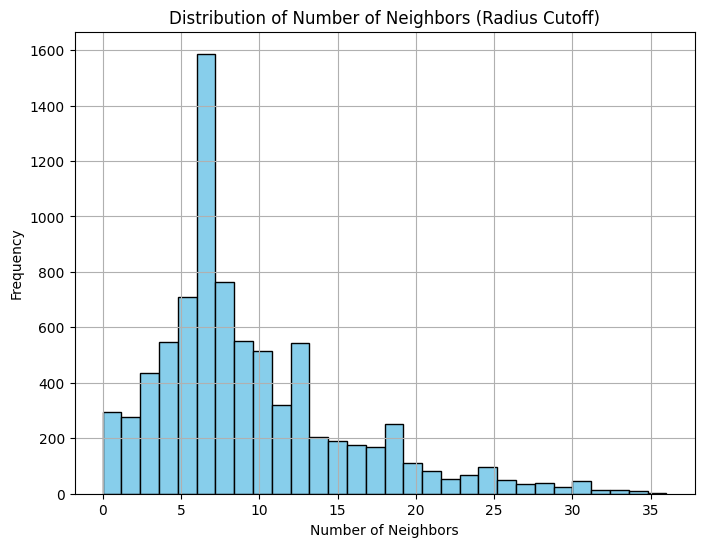

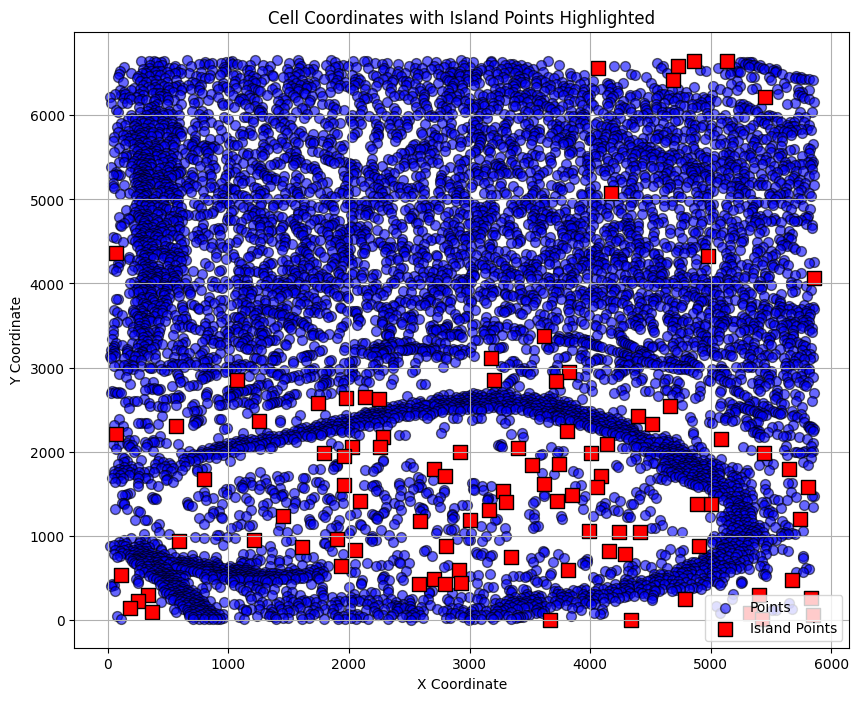

Number of island points: 95
Island point indices: [  10   14   75  116  297  570 2185 3146 3190 3556 4577 4952 5158 5247
 5253 5262 5431 5449 5461 5536 5596 5768 5861 5893 5913 5981 6022 6053
 6068 6128 6156 6162 6173 6224 6227 6229 6239 6256 6328 6333 6387 6389
 6445 6456 6479 6527 6540 6559 6561 6591 6620 6675 6676 6684 6698 6702
 6744 6794 6815 6825 6832 6894 6899 6901 6947 6963 6975 7005 7006 7014
 7036 7050 7078 7122 7249 7348 7349 7462 7573 7579 7616 7637 7639 7790
 7792 7836 7853 7893 7998 8055 8072 8110 8174 8179 8181]


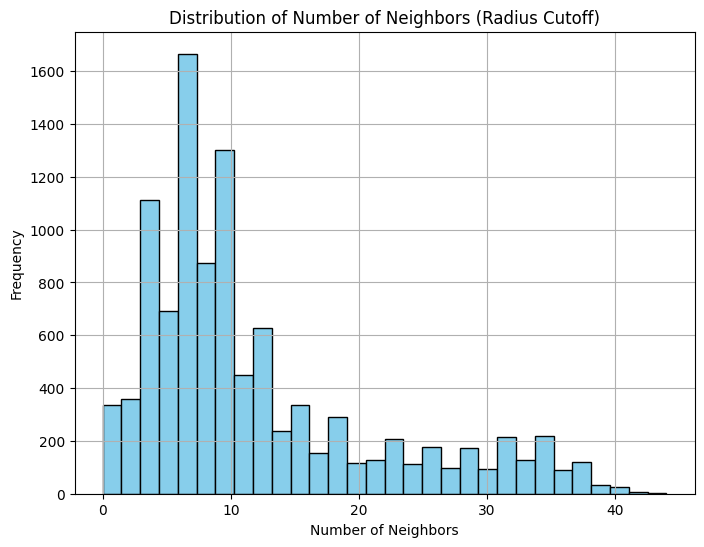

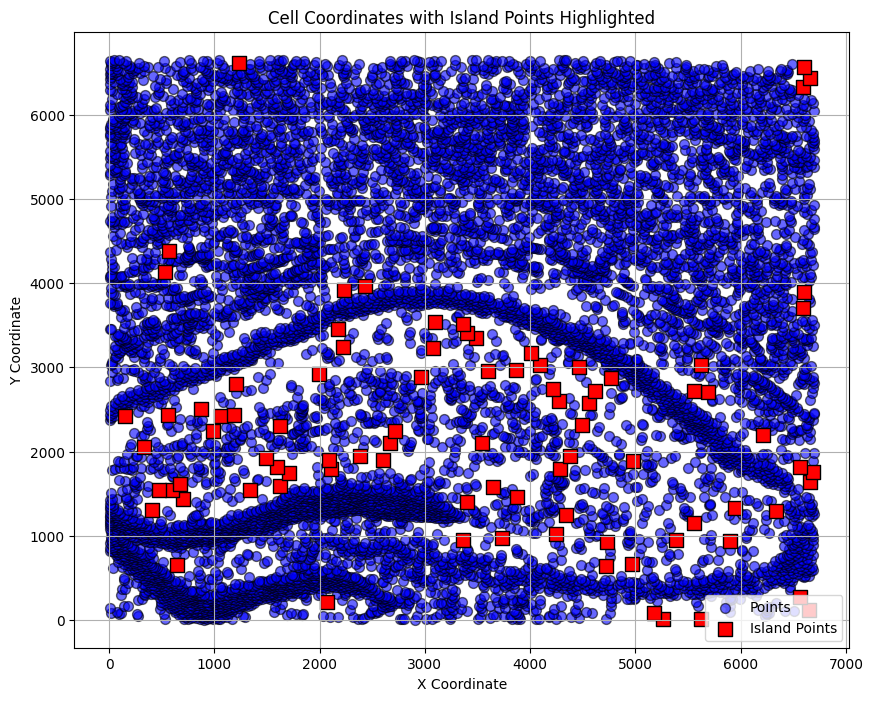

Number of island points: 88
Island point indices: [   10    24   121   161   321   434  1366  1377  1386  1768  1794  1809
  1821  1878  1959  2211  2405  2548  2593  2680  2841  2910  2966  3110
  3116  3118  3161  3166  3186  3209  3298  3306  3335  3336  3362  3363
  3413  3423  3425  3438  3464  3474  3565  3598  3604  3691  3730  3739
  3799  3807  3940  3941  3947  3958  4017  4101  4132  4258  4266  4271
  4310  4381  4437  4462  4504  4544  4549  4580  4609  4639  4785  4848
  4872  5023  5122  5195  5278  5323  5574  5937  5961  6020  6253  6683
  9863 10026 10233 10310]


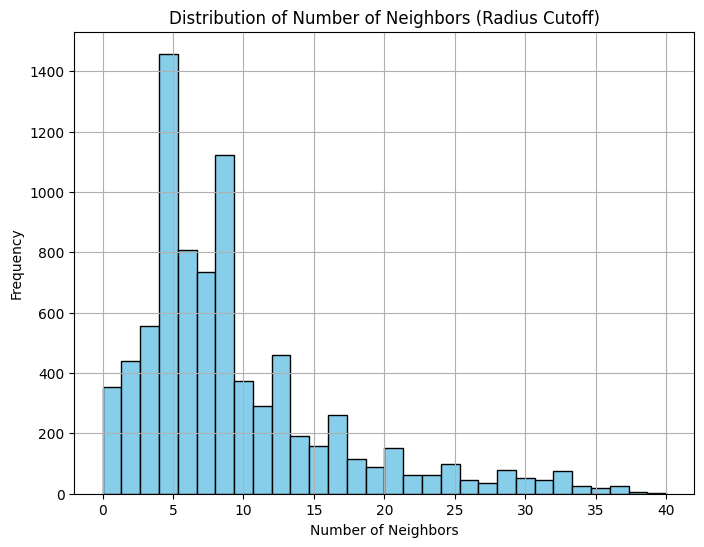

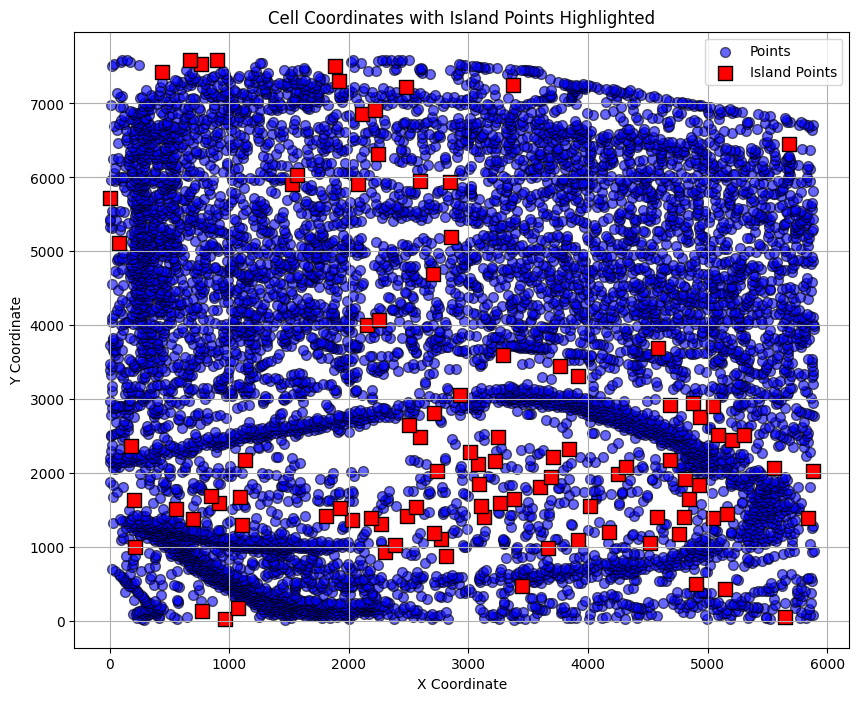

Number of island points: 100
Island point indices: [  18   43  155  239  601  632  672 1165 1215 1289 1313 1374 1426 1502
 1517 1595 1618 1637 1747 1766 1809 1811 1821 1823 1824 1828 1830 1831
 1840 1842 1856 1896 1904 1914 1915 1924 1940 1943 1966 1974 1976 1989
 1994 2085 2106 2126 2165 2177 2197 2222 2224 2249 2259 2292 2328 2332
 2335 2372 2409 2440 2474 2526 2557 2558 2588 2593 2739 2862 2909 3024
 3053 3081 3232 3454 3556 3716 3821 4207 4287 5122 5669 5764 6377 6569
 6575 6619 6632 6732 7035 7199 7678 7710 8032 8043 8083 8133 8172 8180
 8194 8201]


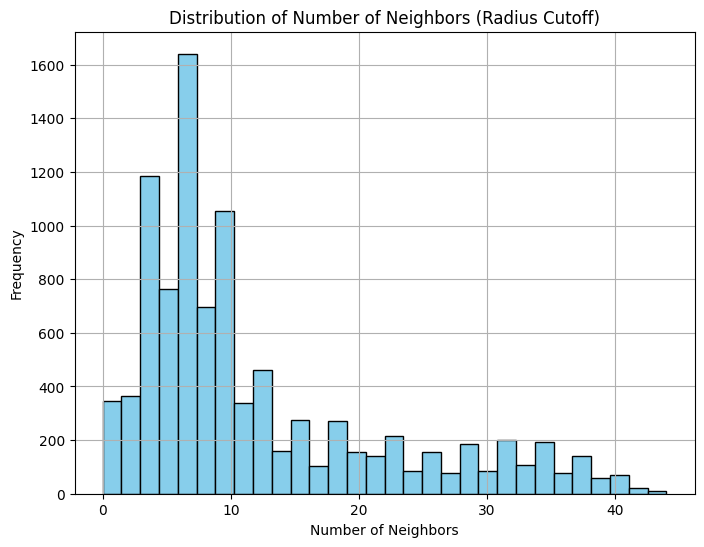

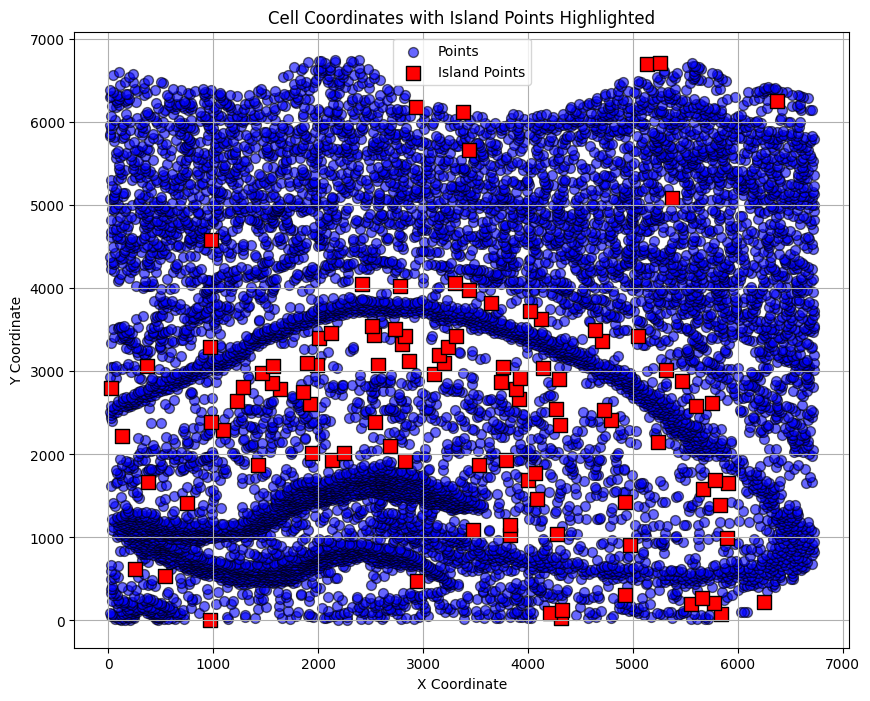

Number of island points: 102
Island point indices: [   2   32  116  137  195  270  275  282  350  380  536  649  871 1703
 1856 1922 1962 2065 2232 2638 2682 2694 2755 3028 3186 3208 3268 3272
 3403 3505 3506 3546 3549 3555 3620 3631 3708 3751 3815 3878 3950 3974
 3985 4000 4133 4154 4187 4212 4220 4241 4285 4360 4387 4397 4416 4423
 4469 4489 4505 4537 4565 4600 4613 4645 4670 4690 4708 4715 4718 4719
 4734 4741 4759 4835 4939 4947 4972 5008 5062 5096 5101 5107 5109 5157
 5203 5238 5286 5393 5583 5799 5982 6026 6062 6080 6839 7639 8517 9231
 9305 9384 9623 9624]


In [28]:
neighbors = {}
for key in cell_coords.keys():
    neighbors[key] = construct_affinity_matrix(cell_coords[key], mode='radius', cutoff=100)

In [23]:

# Load the plaque dataset
img_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/protein_seg_result/"
img_files = os.listdir(img_dir)
img_files = [i for i in img_files if i.endswith(".tiff") and "plaque" in i]
# Read the images

imgs = {}
for i in range(len(img_files)):
    imgs[img_files[i].split(".")[0]] = io.imread(os.path.join(img_dir, img_files[i]))
imgs.keys()
# Rename the imgs to match the adata keys
for key in list(imgs.keys()):
    parts = key.split("_")
    if len(parts) > 1:
        new_key = parts[1] + "_" + parts[2]
        imgs[new_key] = imgs.pop(key)



In [24]:
# Extract patches from the images
patches = {}
for key in imgs.keys():
    patches[key] = extract_patches(imgs[key], cell_coords[key], patch_size=128)

# Extract the positive patches
positive_patches = {}
for key in patches.keys():
    pos_list = []
    for i in range(len(patches[key])):
        if np.sum(patches[key][i]) > 0:
            pos_list.append(patches[key][i])
    positive_patches[key] = pos_list

# Convert the patches to binary and calculate the area of positive pixels for each patch
binary_patches = {}
for key in patches.keys():
    binary_patches[key] = [patch > 0 for patch in patches[key]]
# Calculate the area of positive pixels for each patch
areas = {}
for key in binary_patches.keys():
    areas[key] = [np.sum(patch) for patch in binary_patches[key]]

Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0


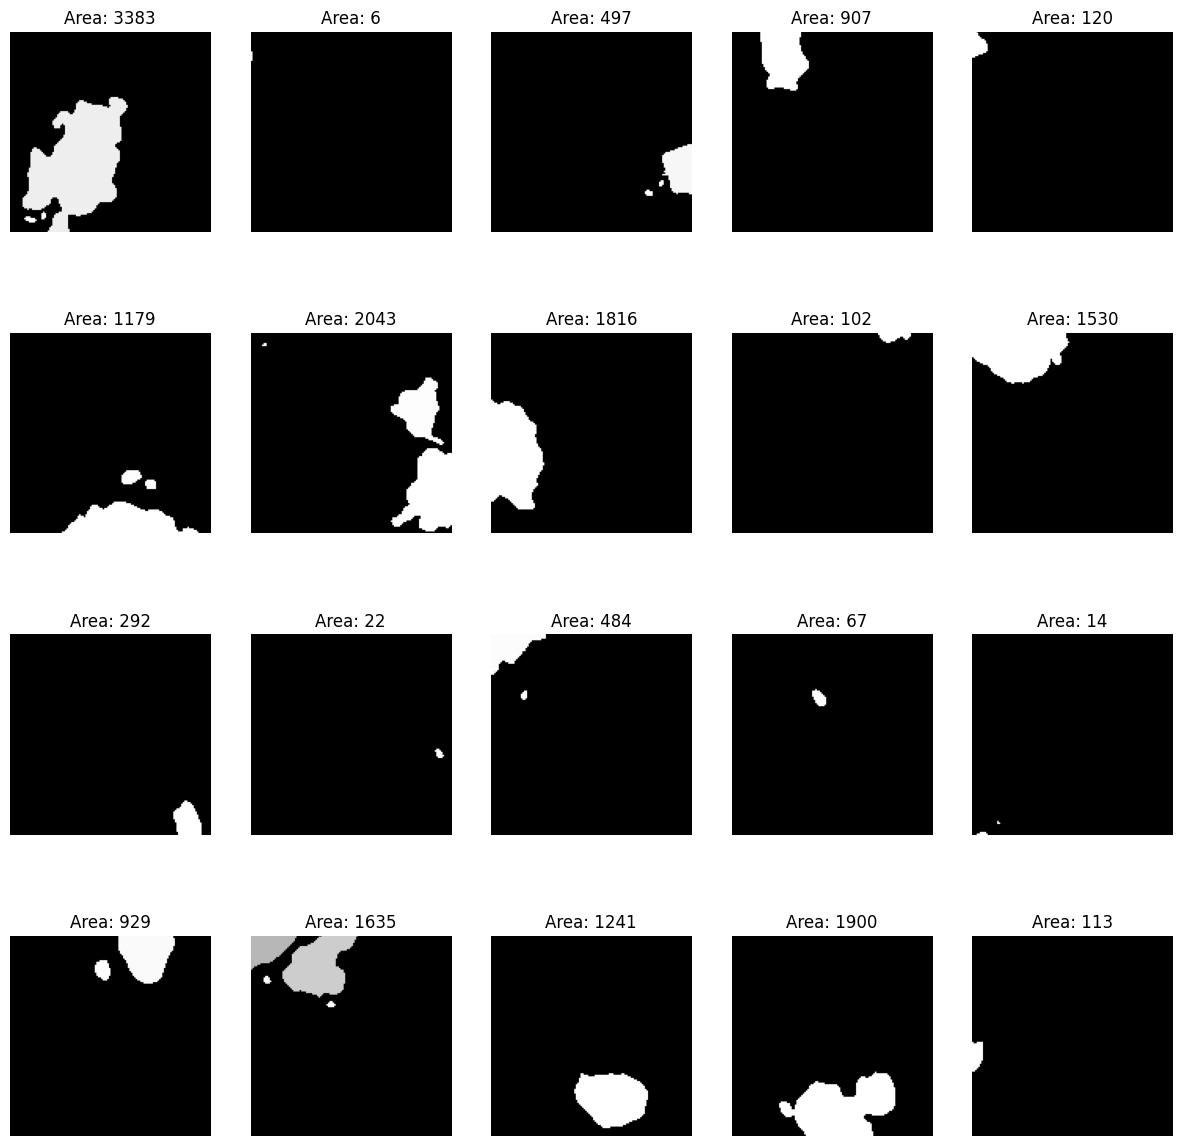

In [25]:
# Choose 5 patches with non-zero area for each image and plot them
import matplotlib.pyplot as plt

# Set the number of patches to plot
n_patches = 5

# Plot the patches
fig, axes = plt.subplots(nrows=len(areas), ncols=n_patches, figsize=(15, 15))
axes = np.atleast_2d(axes)  # Ensure axes is 2D for consistent indexing

for i, key in enumerate(areas.keys()):
    non_zero_indices = np.where(np.array(areas[key]) > 0)[0]
    chosen_indices = random.sample(list(non_zero_indices), n_patches)
    for j, idx in enumerate(chosen_indices):
        axes[i, j].imshow(patches[key][idx], cmap="gray")
        axes[i, j].set_title(f"Area: {areas[key][idx]}")
        axes[i, j].axis("off")
    axes[i, 0].set_ylabel(key, rotation=0, size="large", labelpad=50)

## Graph Construction

In [37]:
import torch
import scipy.sparse
from torch_geometric.data import Data
import numpy as np
from tqdm import tqdm
import pandas as pd

def create_graph_data_dict(adatas, areas, neighbors, cell_coords):
    """
    Create a dictionary of PyTorch Geometric Data objects from AnnData objects.
    
    Parameters:
    - adatas: dict of AnnData objects
    - areas: dict of patch areas
    - neighbors: dict of connectivity matrices (affinity matrices with weights)
    - cell_coords: dict of spatial coordinates
    
    Returns:
    - graph_data_dict: dict of PyTorch Geometric Data objects
    """
    graph_data_dict = {}

    for key in tqdm(adatas.keys(), desc="Creating graph data"):
        # Ensure the keys match between adata and patches
        if key not in areas:
            print(f"Warning: No patch area data for '{key}'. Skipping.")
            continue
        if key not in neighbors:
            print(f"Warning: No neighbors data for '{key}'. Skipping.")
            continue
        if key not in cell_coords:
            print(f"Warning: No cell coordinates data for '{key}'. Skipping.")
            continue


        adata = adatas[key]
        num_cells = adata.n_obs

        # Features: Gene expression data
        # Assuming 'X' is already a NumPy array after preprocessing
        features = adata.X
        if scipy.sparse.issparse(features):
            features = features.toarray()
        features = torch.tensor(features, dtype=torch.float)

        # Labels: Patch areas
        label_areas = areas[key]
        if len(label_areas) != num_cells:
            print(f"Warning: Number of patches and cells do not match for '{key}'.")
            # Handle mismatch by trimming to the minimum length
            min_len = min(len(label_areas), num_cells)
            label_areas = label_areas[:min_len]
            features = features[:min_len]
            num_cells = min_len  # Update num_cells accordingly

        labels = torch.tensor(label_areas, dtype=torch.float).unsqueeze(1)  # Shape: [num_nodes, 1]

        # Edges: Connectivity matrix (Affinity matrix with weights)
        connectivity = neighbors[key].tocoo()

        # Extract edge indices
        edge_index = torch.tensor(
            np.vstack([connectivity.row, connectivity.col]),
            dtype=torch.long
        )

        # Extract edge weights (inverse distances)
        edge_weights = torch.tensor(connectivity.data, dtype=torch.float).unsqueeze(1)  # Shape: [num_edges, 1]

        # Create PyTorch Geometric Data object
        data = Data(
            x=features,
            edge_index=edge_index,
            edge_attr=edge_weights,
            y=labels
        )

        # Optionally, add additional information (e.g., spatial coordinates)
        spatial = torch.tensor(cell_coords[key], dtype=torch.float)
        data.pos = spatial  # 'pos' is a standard attribute in PyTorch Geometric for node positions
        

        # Add to the dictionary
        graph_data_dict[key] = data

    return graph_data_dict



# Create the graph dictionary
graph_data_dict = create_graph_data_dict(adatas, areas, neighbors, cell_coords)


# Efficiently convert patches to tensors in batch
for key, graph in tqdm(graph_data_dict.items(), desc="Adding patches to graph data"):
    # Ensure patches[key] is a list of NumPy arrays
    patches_tensor = torch.tensor(np.array(patches[key]), dtype=torch.float)  # Convert patches to a single tensor efficiently
    graph.patches = patches_tensor



Adding patches to graph data: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


In [38]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 76592], edge_attr=[76592, 1], y=[8186, 1], pos=[8186, 2], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 123704], edge_attr=[123704, 1], y=[10372, 1], pos=[10372, 2], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 75568], edge_attr=[75568, 1], y=[8202, 1], pos=[8202, 2], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 115726], edge_attr=[115726, 1], y=[9634, 1], pos=[9634, 2], patches=[9634, 128, 128, 1])}

In [41]:
graph_data_dict['13months-disease-replicate_1'].edge_attr.shape

torch.Size([123704, 1])

In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cuda')

In [14]:
# Check system's gpu info
!nvidia-smi


Wed Dec 25 21:27:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:1F:00.0 Off |                    0 |
| N/A   34C    P0              84W / 350W |   6694MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [15]:
torch.version.cuda

'12.4'

# Prediction & Represenation of the graph

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool


In [134]:
test_replicate_name = '13months-disease-replicate_2'


In [135]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_val_datalist = []
test_data = None

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    data.y = (data.y > 0).float()  # Binarize

    if name == test_replicate_name:
        # This entire graph is our final test set.
        test_data = data
    else:
        # We do random node-level splits for training & validation
        num_nodes = data.x.size(0)
        perm = torch.randperm(num_nodes)

        train_cutoff = int(0.8 * num_nodes)
        val_cutoff   = int(0.9 * num_nodes)

        data.train_idx = perm[:train_cutoff]
        data.val_idx   = perm[train_cutoff:val_cutoff]
        data.mini_test_idx = perm[val_cutoff:]  # optional mini-test

        train_val_datalist.append(data)

# Move test_data to device
test_data = test_data.to(device)


In [136]:
class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, residual=True, dropout=0.5):
        super().__init__()
        
        # -- GCN Layer --
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        # -- GraphSAGE Layer --
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        # Optional skip connection parameter
        self.residual = residual

        # -- Final MLP block --
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, out_channels)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None):
        # --- First layer: GCN ---
        out1 = self.conv1(x, edge_index)
        out1 = self.bn1(out1)
        out1 = F.relu(out1)
        out1 = self.dropout(out1)
        
        # --- Second layer: GraphSAGE ---
        out2 = self.conv2(out1, edge_index)
        out2 = self.bn2(out2)
        out2 = F.relu(out2)
        out2 = self.dropout(out2)
        
        # --- Residual Connection (optional) ---
        if self.residual:
            out2 = out1 + out2  # Skip connection

        # If graph-level classification, you'd pool here:
        #   out2 = global_mean_pool(out2, batch)
        # But for node-level, we skip global pooling.

        # --- Final MLP (per node) ---
        out = self.mlp(out2)

        return out


In [137]:
def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


criterion = nn.BCEWithLogitsLoss()

def train_classifier(model, optimizer, datalist):
    """ Train on the 'train_idx' of each graph in datalist. """
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index).squeeze()  # shape: [num_nodes]
        
        train_labels = data.y[data.train_idx].view(-1)
        train_preds  = out[data.train_idx]              # shape: [num_train_nodes]
        
        loss = criterion(train_preds, train_labels)
        loss.backward()
        total_loss += loss.item()
    
    # Single optimizer step for all graphs combined
    optimizer.step()
    return total_loss / len(datalist)


@torch.no_grad()
def evaluate_classifier(model, datalist, split="val_idx"):
    """
    Evaluate the model on the given split of each graph in datalist.
    Return average (loss, accuracy, AUC) across all graphs.
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_nodes   = 0
    all_labels    = []
    all_scores    = []
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index).squeeze()
        
        idx = getattr(data, split)  # e.g. data.val_idx
        labels = data.y[idx].view(-1)
        preds  = out[idx]
        
        # BCEWithLogitsLoss
        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        # Accuracy
        prob = torch.sigmoid(preds)
        binary_pred = (prob > 0.5).float()
        correct = (binary_pred == labels).sum().item()
        
        total_correct += correct
        total_nodes   += len(labels)
        
        # For AUC
        all_labels.append(labels.cpu())
        all_scores.append(prob.cpu())
    
    avg_loss = total_loss / len(datalist)
    avg_acc  = total_correct / total_nodes
    
    # Compute AUC across all graphs combined
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_scores = torch.cat(all_scores, dim=0).numpy()
    try:
        auc = roc_auc_score(all_labels, all_scores)
    except ValueError:
        # If all labels are 0 or 1, AUC can be undefined
        auc = float('nan')
    
    return avg_loss, avg_acc, auc


In [138]:
in_channels = train_val_datalist[0].x.size(1)

pre_model = GNNClassifier(
    in_channels=in_channels,
    hidden_channels=128,
    dropout=0.6
).to(device)

pre_model.apply(weights_init)

optimizer = torch.optim.Adam(pre_model.parameters(), lr=0.0001)


Training on multiple graphs: 100%|██████████| 1000/1000 [00:23<00:00, 43.29it/s]


Best validation accuracy: 0.9305


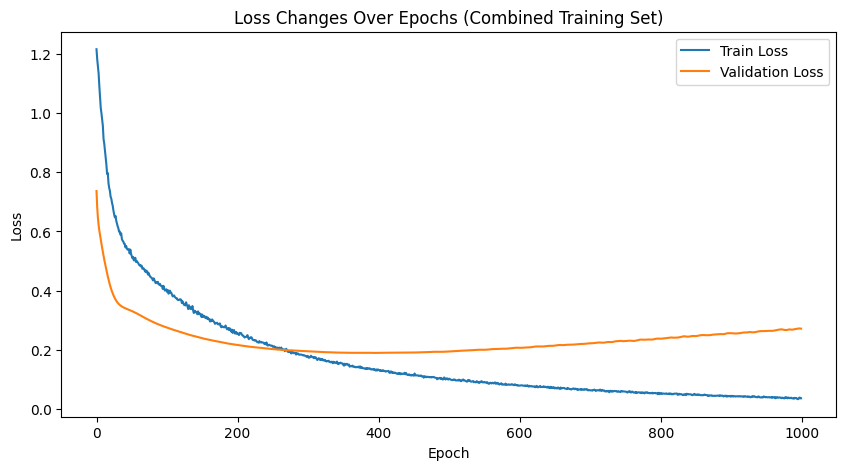

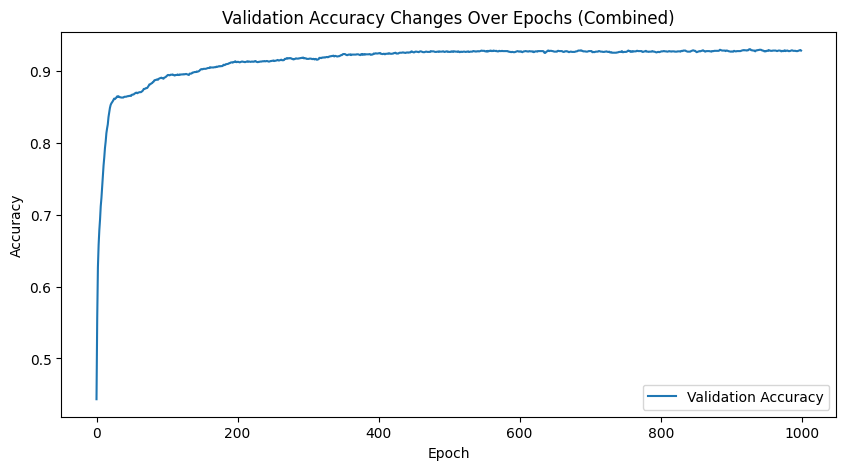

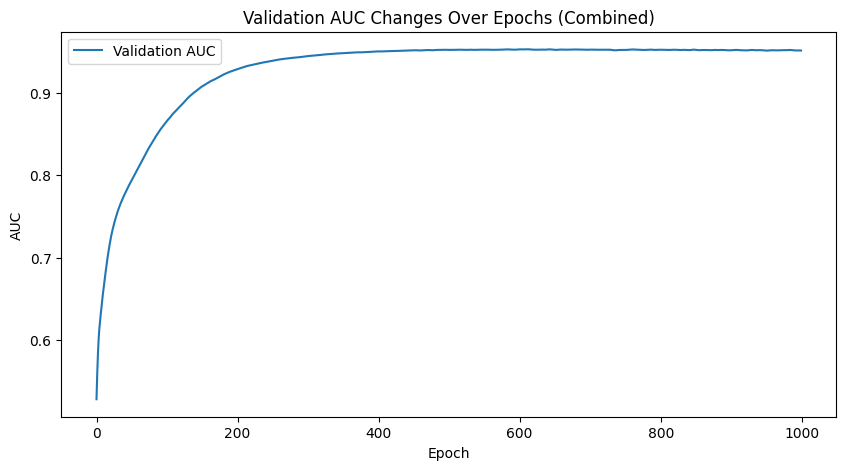

In [139]:
best_val_acc = 0.0
best_state = None

train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

EPOCHS = 1000
for epoch in tqdm(range(EPOCHS), desc="Training on multiple graphs"):
    # 1) Train step (all training graphs)
    train_loss = train_classifier(pre_model, optimizer, train_val_datalist)
    train_losses.append(train_loss)

    # 2) Validation step (all training graphs)
    val_loss, val_acc, val_auc = evaluate_classifier(pre_model, train_val_datalist, split="val_idx")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    # Track best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = pre_model.state_dict()

# Reload best model
if best_state is not None:
    pre_model.load_state_dict(best_state)

print(f"Best validation accuracy: {best_val_acc:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Changes Over Epochs (Combined Training Set)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Changes Over Epochs (Combined)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC Changes Over Epochs (Combined)')
plt.show()



In [140]:
@torch.no_grad()
def test_on_withheld_graph(model, data):
    model.eval()
    data = data.to(device)
    
    logits = model(data.x, data.edge_index).squeeze()
    labels = data.y.view(-1)
    
    loss = criterion(logits, labels).item()
    probs = torch.sigmoid(logits)
    binary_pred = (probs > 0.5).float()
    
    correct = (binary_pred == labels).sum().item()
    acc = correct / labels.size(0)
    
    try:
        auc = roc_auc_score(labels.cpu(), probs.cpu())
    except ValueError:
        auc = float('nan')
    
    return loss, acc, auc

test_loss, test_acc, test_auc = test_on_withheld_graph(pre_model, test_data)
print(f"\n=== Final Test on '{test_replicate_name}' ===")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test AUC: {test_auc:.4f}")



=== Final Test on '13months-disease-replicate_2' ===
Test Loss: 0.4332 | Test Accuracy: 0.9247 | Test AUC: 0.8553


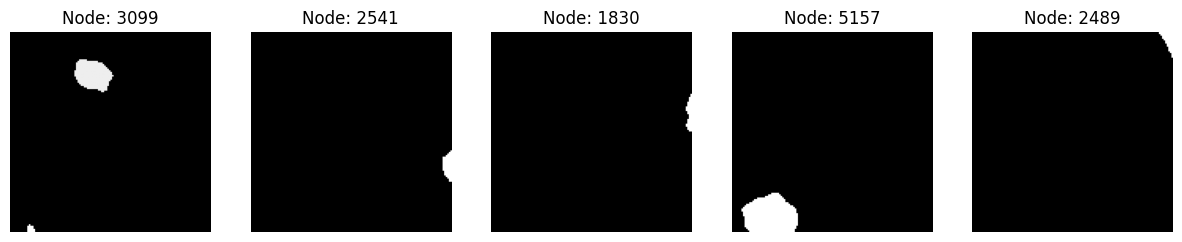

In [141]:
# Get predictions from the classifier
pre_model.eval()
data = graph_data_dict['8months-disease-replicate_1'].clone().to(device)
with torch.no_grad():
    logits = pre_model(data.x, data.edge_index).squeeze()
    preds = (logits.sigmoid() > 0.5).float()

# Identify positive nodes
positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]

# Visualize a subset of the positive nodes' patches images
num_images_to_plot = min(5, len(positive_nodes))  # Plot up to 5 images
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))
axes = np.atleast_1d(axes)

# Randomly select positive nodes to plot
random_positive_nodes = random.sample(list(positive_nodes), num_images_to_plot)

for i, node in enumerate(random_positive_nodes):
    patch = data.patches[node].squeeze().to("cpu").numpy()
    axes[i].imshow(patch, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Node: {node.item()}")
plt.show()


In [116]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 76592], edge_attr=[76592, 1], y=[8186, 1], pos=[8186, 2], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 123704], edge_attr=[123704, 1], y=[10372, 1], pos=[10372, 2], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 75568], edge_attr=[75568, 1], y=[8202, 1], pos=[8202, 2], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 115726], edge_attr=[115726, 1], y=[9634, 1], pos=[9634, 2], patches=[9634, 128, 128, 1])}

In [142]:
# Store the positive nodes in a dictionary
positive_nodes_dict = {}

for key, data in graph_data_dict.items():
    data = data.clone().to(device)
    with torch.no_grad():
        logits = pre_model(data.x, data.edge_index).squeeze()
        preds = (logits.sigmoid() > 0.5).float()
    positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]
    positive_nodes_dict[key] = positive_nodes

#  Print the number of positive nodes for each replicate
for key, nodes in positive_nodes_dict.items():
    print(f"Number of positive nodes in '{key}': {len(nodes)}")

Number of positive nodes in '8months-disease-replicate_1': 823
Number of positive nodes in '13months-disease-replicate_1': 2496
Number of positive nodes in '8months-disease-replicate_2': 945
Number of positive nodes in '13months-disease-replicate_2': 631


In [ ]:
graph_data_dict['8months-disease-replicate_1'].edge_attr

In [130]:
# Save the graph data dictionary and the positive nodes dictionary
save_dir = "/public/home/jijh/diffusion_project/data_storage"

torch.save(graph_data_dict, os.path.join(save_dir,"not_scaled_graph_data_dict.pth"))
torch.save(positive_nodes_dict, os.path.join(save_dir,"not_scaled_positive_nodes_dict.pth"))

# Exact plaque size prediction

/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training:   0%|          | 4/5000 [00:00<04:50, 17.19it/s]

Epoch 0: Train Loss=7.6145, Val RMSE=2.5278, Val R²=-0.3440


Training:   2%|▏         | 104/5000 [00:05<03:56, 20.72it/s]

Epoch 100: Train Loss=0.8911, Val RMSE=1.4391, Val R²=0.5644


Training:   4%|▍         | 210/5000 [00:08<01:29, 53.61it/s]

Epoch 200: Train Loss=0.6714, Val RMSE=1.5117, Val R²=0.5193


Training:   6%|▌         | 312/5000 [00:10<01:24, 55.52it/s]

Epoch 300: Train Loss=0.5605, Val RMSE=1.5374, Val R²=0.5028


Training:   8%|▊         | 408/5000 [00:12<01:22, 55.51it/s]

Epoch 400: Train Loss=0.5547, Val RMSE=1.5851, Val R²=0.4715


Training:  10%|█         | 511/5000 [00:14<01:23, 53.48it/s]

Epoch 500: Train Loss=0.5149, Val RMSE=1.5794, Val R²=0.4753


Training:  12%|█▏        | 599/5000 [00:15<01:56, 37.77it/s]


Early stopping!
Best validation RMSE: 1.4355


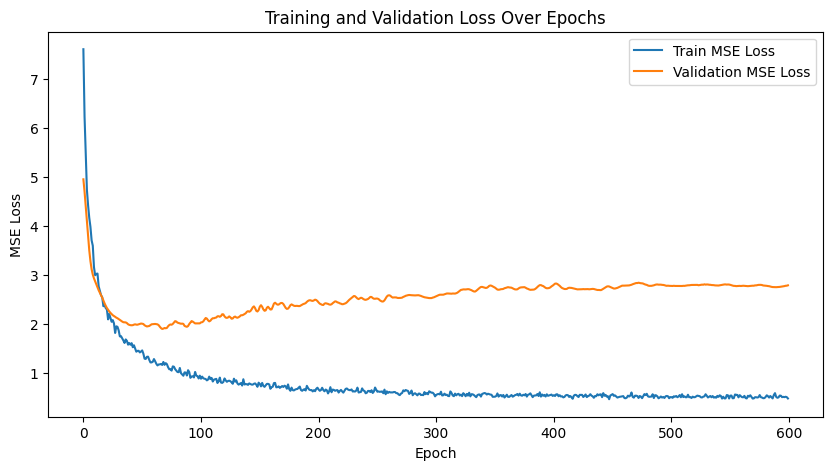

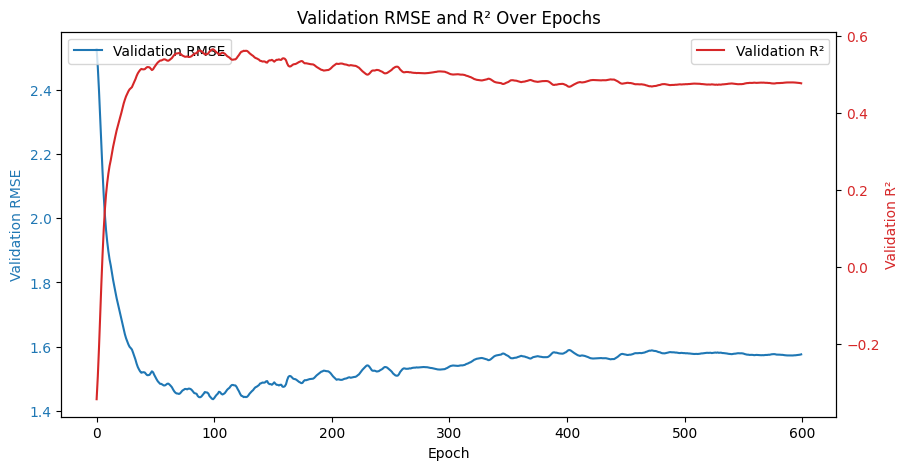

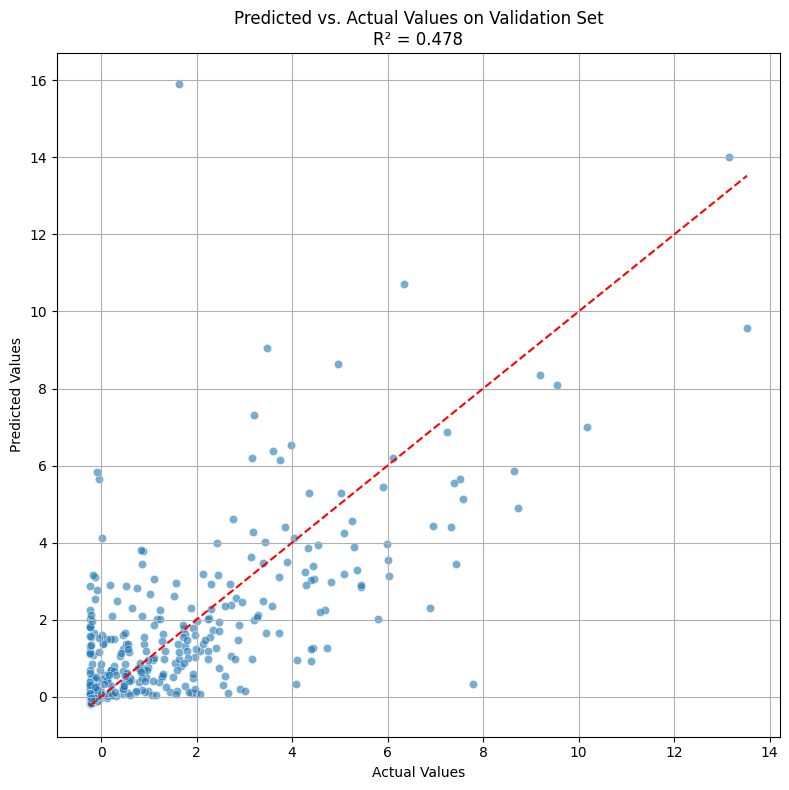


=== Final Test on '13months-disease-replicate_2' ===
Test MSE: 1589764.0000 | Test MAE: 938.8752 | Test RMSE: 1260.8584 | Test R²: -1.0136


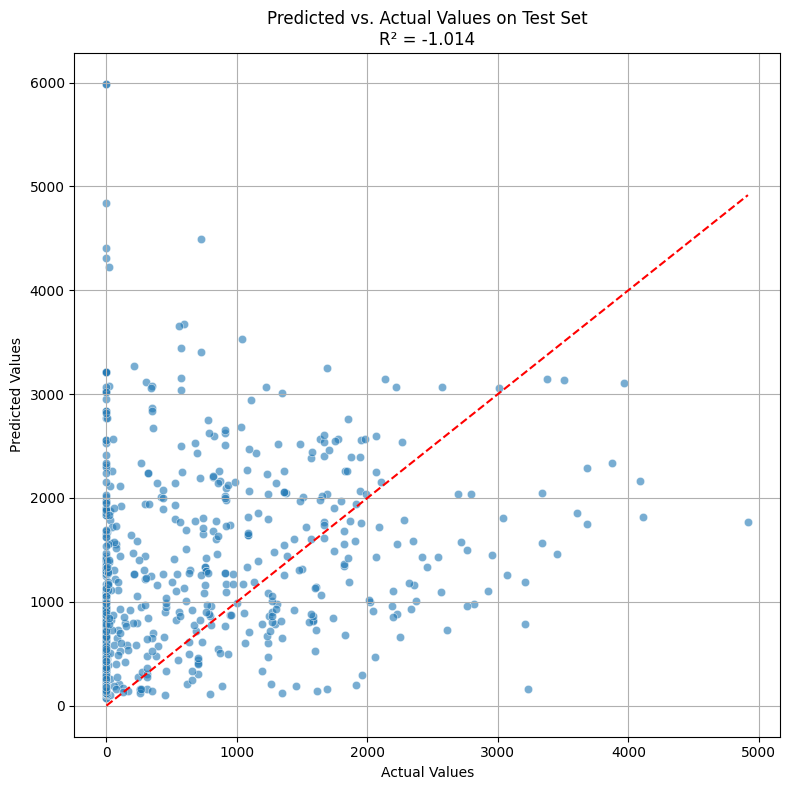

In [190]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from tqdm import tqdm  # For progress bar

# =====================================
# Step 1: Data Preparation
# =====================================

# Assuming graph_data_dict and positive_nodes_dict are predefined
# Example:
# graph_data_dict = {
#     'graph1': Data(x=..., edge_index=..., y=...),
#     'graph2': Data(x=..., edge_index=..., y=...),
#     ...
# }
# positive_nodes_dict = {
#     'graph1': torch.tensor([...]),
#     'graph2': torch.tensor([...]),
#     ...
# }

test_replicate_name = '13months-disease-replicate_2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_val_datalist = []
test_data = None

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Collect all node features and targets for scaling
all_features = []
all_targets = []

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    all_features.append(data.x.cpu().numpy())
    all_targets.append(data.y.cpu().numpy())

# Fit scalers
all_features = np.vstack(all_features)
feature_scaler.fit(all_features)

all_targets = np.concatenate(all_targets).reshape(-1, 1)
target_scaler.fit(all_targets)

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    
    # Normalize node features
    data.x = torch.tensor(feature_scaler.transform(data.x.cpu()), dtype=torch.float32)
    
    # Normalize target
    data.y = torch.tensor(target_scaler.transform(data.y.cpu().numpy().reshape(-1, 1)).flatten(), dtype=torch.float32)
    
    if name == test_replicate_name:
        # Assign the entire test graph
        test_data = data.to(device)
        # Assign only positive nodes for testing
        test_data.test_idx = positive_nodes_dict[name].to(device)
    else:
        # Retrieve positive nodes for the current graph
        positive_nodes = positive_nodes_dict[name]
        num_positive = positive_nodes.size(0)
        
        if num_positive == 0:
            print(f"No positive nodes found in '{name}'. Skipping this graph.")
            continue  # Skip graphs with no positive nodes
        
        # Shuffle positive node indices
        perm = torch.randperm(num_positive)
        
        # Split positive nodes into train and validation
        train_cutoff = int(0.8 * num_positive)
        val_cutoff   = int(0.9 * num_positive)
        
        data.train_idx = positive_nodes[perm[:train_cutoff]].to(device)
        data.val_idx   = positive_nodes[perm[train_cutoff:val_cutoff]].to(device)
        # data.mini_test_idx = positive_nodes[perm[val_cutoff:]].to(device)  # Optional
        
        train_val_datalist.append(data.to(device))

test_datalist = [test_data] if test_data is not None else []

# =====================================
# Step 2: Define the Simplified GNN Regressor Model
# =====================================

class SimplifiedGNNRegressor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, dropout=0.3):
        super(SimplifiedGNNRegressor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, out_channels)
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc(x)
        return x.squeeze()  # [num_nodes]

# =====================================
# Step 3: Initialize Model, Optimizer, and Loss Function
# =====================================

def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv1d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Determine the number of input features
if not train_val_datalist:
    raise ValueError("No training/validation data available. Check positive_nodes_dict and graph_data_dict.")
in_channels = train_val_datalist[0].x.size(1)

# Initialize the model
model = SimplifiedGNNRegressor(
    in_channels=in_channels,
    hidden_channels=64,  # Reduced from 128
    dropout=0.3  # Reduced from 0.6
).to(device)

# Apply weight initialization
model.apply(weights_init)

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

# Define the loss function
criterion = nn.MSELoss()

# =====================================
# Step 4: Define Training and Evaluation Functions
# =====================================

@torch.no_grad()
def evaluate_regressor(model, datalist, split="val_idx"):
    """
    Evaluate the model on the given split of each graph in datalist.
    Returns average MSE, MAE, RMSE, MAE overall, R², and all labels and predictions.
    """
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    total_nodes = 0
    all_labels = []
    all_preds = []
    
    for data in datalist:
        out = model(data.x, data.edge_index).squeeze()
        
        idx = getattr(data, split, None)
        if idx is None or idx.numel() == 0:
            continue
        
        labels = data.y[idx].view(-1)
        preds = out[idx]
        
        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        mae = F.l1_loss(preds, labels, reduction='sum').item()
        total_mae += mae
        
        total_nodes += labels.size(0)
        
        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
    
    if total_nodes == 0:
        return float('nan'), float('nan'), float('nan'), float('nan'), None, None
    
    avg_loss = total_loss / len(datalist)
    avg_mae = total_mae / total_nodes
    
    all_labels_np = torch.cat(all_labels, dim=0).numpy()
    all_preds_np = torch.cat(all_preds, dim=0).numpy()
    
    rmse = np.sqrt(mean_squared_error(all_labels_np, all_preds_np))
    mae_overall = mean_absolute_error(all_labels_np, all_preds_np)
    r2 = r2_score(all_labels_np, all_preds_np)
    
    return avg_loss, avg_mae, rmse, mae_overall, r2, (all_labels_np, all_preds_np)

def train_regressor(model, optimizer, datalist):
    """ Train on the 'train_idx' of each graph in datalist. """
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0
    
    for data in datalist:
        out = model(data.x, data.edge_index).squeeze()
        
        if data.train_idx.numel() == 0:
            continue  # Skip if there are no training nodes
        
        train_labels = data.y[data.train_idx].view(-1)
        train_preds  = out[data.train_idx]              # shape: [num_train_nodes]
        
        loss = criterion(train_preds, train_labels)
        loss.backward()
        total_loss += loss.item()
    
    # Gradient clipping (optional)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    
    # Single optimizer step for all graphs combined
    optimizer.step()
    
    return total_loss / len(datalist)

# =====================================
# Step 5: Training Loop with Early Stopping
# =====================================

best_val_rmse = float('inf')
best_state = None
patience = 500
trigger_times = 0

train_losses = []
val_losses = []
val_maes = []
val_rmses = []
val_r2s = []

test_losses = []
test_maes = []
test_rmses = []
test_r2s = []

EPOCHS = 5000
for epoch in tqdm(range(EPOCHS), desc="Training"):
    # 1) Train step (all training graphs)
    train_loss = train_regressor(model, optimizer, train_val_datalist)
    train_losses.append(train_loss)

    # 2) Validation step (all training graphs)
    val_loss, val_mae, val_rmse, val_mae_overall, val_r2, _ = evaluate_regressor(model, train_val_datalist, split="val_idx")
    val_losses.append(val_loss)
    val_maes.append(val_mae)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    # 3) Update scheduler
    scheduler.step(val_loss)

    # 4) Early Stopping Check
    if not np.isnan(val_rmse) and val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1

    if trigger_times >= patience:
        print("Early stopping!")
        break

    # Optional: Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val RMSE={val_rmse:.4f}, Val R²={val_r2:.4f}")

# Load Best Model
if best_state:
    model.load_state_dict(best_state)

print(f"Best validation RMSE: {best_val_rmse:.4f}")

# =====================================
# Step 6: Plotting Results
# =====================================

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MSE Loss')
plt.plot(val_losses, label='Validation MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Plot Validation RMSE and R²
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation RMSE', color=color)
ax1.plot(val_rmses, color=color, label='Validation RMSE')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation R²', color=color)
ax2.plot(val_r2s, color=color, label='Validation R²')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Validation RMSE and R² Over Epochs')
plt.show()

# Scatter Plot: Predicted vs. Actual on Validation Set
_, _, _, _, val_r2, (val_labels, val_preds) = evaluate_regressor(
    model, 
    train_val_datalist, 
    split="val_idx"
)

if val_labels is not None and val_preds is not None:
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=val_labels, y=val_preds, alpha=0.6)
    plt.plot([val_labels.min(), val_labels.max()], [val_labels.min(), val_labels.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs. Actual Values on Validation Set\nR² = {val_r2:.3f}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No positive nodes available in the validation split for plotting.")

# =====================================
# Step 7: Final Testing on Withheld Graph
# =====================================

@torch.no_grad()
def test_on_withheld_graph_regression(model, data):
    model.eval()
    out = model(data.x, data.edge_index).squeeze()
    
    idx = data.test_idx  # Use only positive nodes for testing
    if idx.numel() == 0:
        print("No positive nodes in the test graph.")
        return float('nan'), float('nan'), float('nan'), float('nan')
    
    labels = data.y[idx].view(-1)
    preds  = out[idx]
    
    # Inverse transform to original scale
    labels = target_scaler.inverse_transform(labels.cpu().numpy().reshape(-1, 1)).flatten()
    preds = target_scaler.inverse_transform(preds.cpu().numpy().reshape(-1, 1)).flatten()
    
    loss = mean_squared_error(labels, preds)
    mae = mean_absolute_error(labels, preds)
    rmse = np.sqrt(loss)
    r2 = r2_score(labels, preds)
    
    return loss, mae, rmse, r2

if test_data is not None:
    test_loss, test_mae, test_rmse, test_r2 = test_on_withheld_graph_regression(model, test_data)
    print(f"\n=== Final Test on '{test_replicate_name}' ===")
    print(f"Test MSE: {test_loss:.4f} | Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f} | Test R²: {test_r2:.4f}")
else:
    print("No test data available.")

# Optional: Scatter Plot for Test Set
if test_data is not None:
    with torch.no_grad():
        out = model(test_data.x, test_data.edge_index).squeeze()
        idx = test_data.test_idx
        labels = test_data.y[idx].view(-1)
        preds = out[idx]
        
        # Inverse transform to original scale
        labels = target_scaler.inverse_transform(labels.cpu().numpy().reshape(-1, 1)).flatten()
        preds = target_scaler.inverse_transform(preds.cpu().numpy().reshape(-1, 1)).flatten()
        
        if len(labels) > 0:
            test_r2 = r2_score(labels, preds)
            plt.figure(figsize=(8, 8))
            sns.scatterplot(x=labels, y=preds, alpha=0.6)
            plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.title(f'Predicted vs. Actual Values on Test Set\nR² = {test_r2:.3f}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("No positive nodes available in the test split for plotting.")


In [164]:
def check_nan_in_edge_indices(datalist):
    for idx, data in enumerate(datalist):
        edge_idx = data.edge_index
        if torch.isnan(edge_idx).any():
            print(f"NaNs found in edge indices for graph index {idx}.")
            return True
    print("No NaNs found in edge indices.")
    return False

# Usage
has_nan_edge = check_nan_in_edge_indices(train_val_datalist)
if has_nan_edge:
    # Handle NaNs appropriately
    pass


No NaNs found in edge indices.


# Could Start From Here

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Reload the saved dictionaries
save_dir = "./diffusion_project/data_storage"
graph_data_dict = torch.load(os.path.join(save_dir,"graph_data_dict.pth"))
positive_nodes_dict = torch.load(os.path.join(save_dir,"positive_nodes_dict.pth"))


/tmp/ipykernel_113761/3209505670.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data_dict = torch.load(os.path.join(save_dir,"graph_data_dict.pth"))
/tmp/ipykerne

In [122]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131356], y=[8186, 1], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 167278], y=[10372, 1], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 132328], y=[8202, 1], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 155576], y=[9634, 1], patches=[9634, 128, 128, 1])}

# Try to use diffusers to construct the latent conditional diffusion model

## VAE

In [60]:
# Import transform functions from torchvision
from torchvision.transforms import transforms

# Create a dataset of only positive patches
class PositivePatchDataset(Dataset):
    def __init__(self, patches, device):
        self.patches = patches.to(device)
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
        ])

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]  # [1,128,128]
        # Convert to PIL and back to tensor for augmentations
        patch_np = (patch.squeeze(0).cpu().numpy() * 255).astype(np.uint8)
        # Now apply transforms
        patch_pil = transforms.ToPILImage()(patch_np)
        patch_pil = self.transform(patch_pil)
        patch_tensor = transforms.ToTensor()(patch_pil).to(self.patches.device)  # [1,128,128], float in [0,1]
        return patch_tensor
    
# Filter for positive nodes
positive_pathces = []

for key, data in graph_data_dict.items():
    positive_nodes = positive_nodes_dict[key].cpu()
    positive_patches_sample = data.patches[positive_nodes].permute(0, 3, 1, 2)  # [num_positive, 1, 128, 128]
    positive_pathces.append(positive_patches_sample)

# Concatenate all positive patches
positive_patches_sample = torch.cat(positive_pathces, dim=0)

# Create a DataLoader for the positive patches
positive_dataset = PositivePatchDataset(positive_patches_sample, device)
plaque_loader = DataLoader(positive_dataset, batch_size=32, shuffle=True)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [187]:
# Check torch version
torch.__version__

'2.5.1+cu124'

In [28]:
from diffusers import AutoencoderKL

In [29]:
# Define the autoencoder model

vae = AutoencoderKL(in_channels=1, out_channels=1, down_block_types=("DownEncoderBlock2D", "DownEncoderBlock2D", ), 
                    up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", ), block_out_channels=(64, 128, )).to(device)

In [173]:
# Test for loss calculation
test_batch = next(iter(plaque_loader['val']))
test_batch = test_batch.to(device)
test_recon = vae(test_batch)

Attributes of test_recon: ['__annotations__', '__class__', '__class_getitem__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__or__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'commit_loss', 'copy', 'fromkeys', 'get', 'items', 'keys', 'move_to_end', 'pop', 'popitem', 'sample', 'setdefault', 'to_tuple', 'update', 'values']


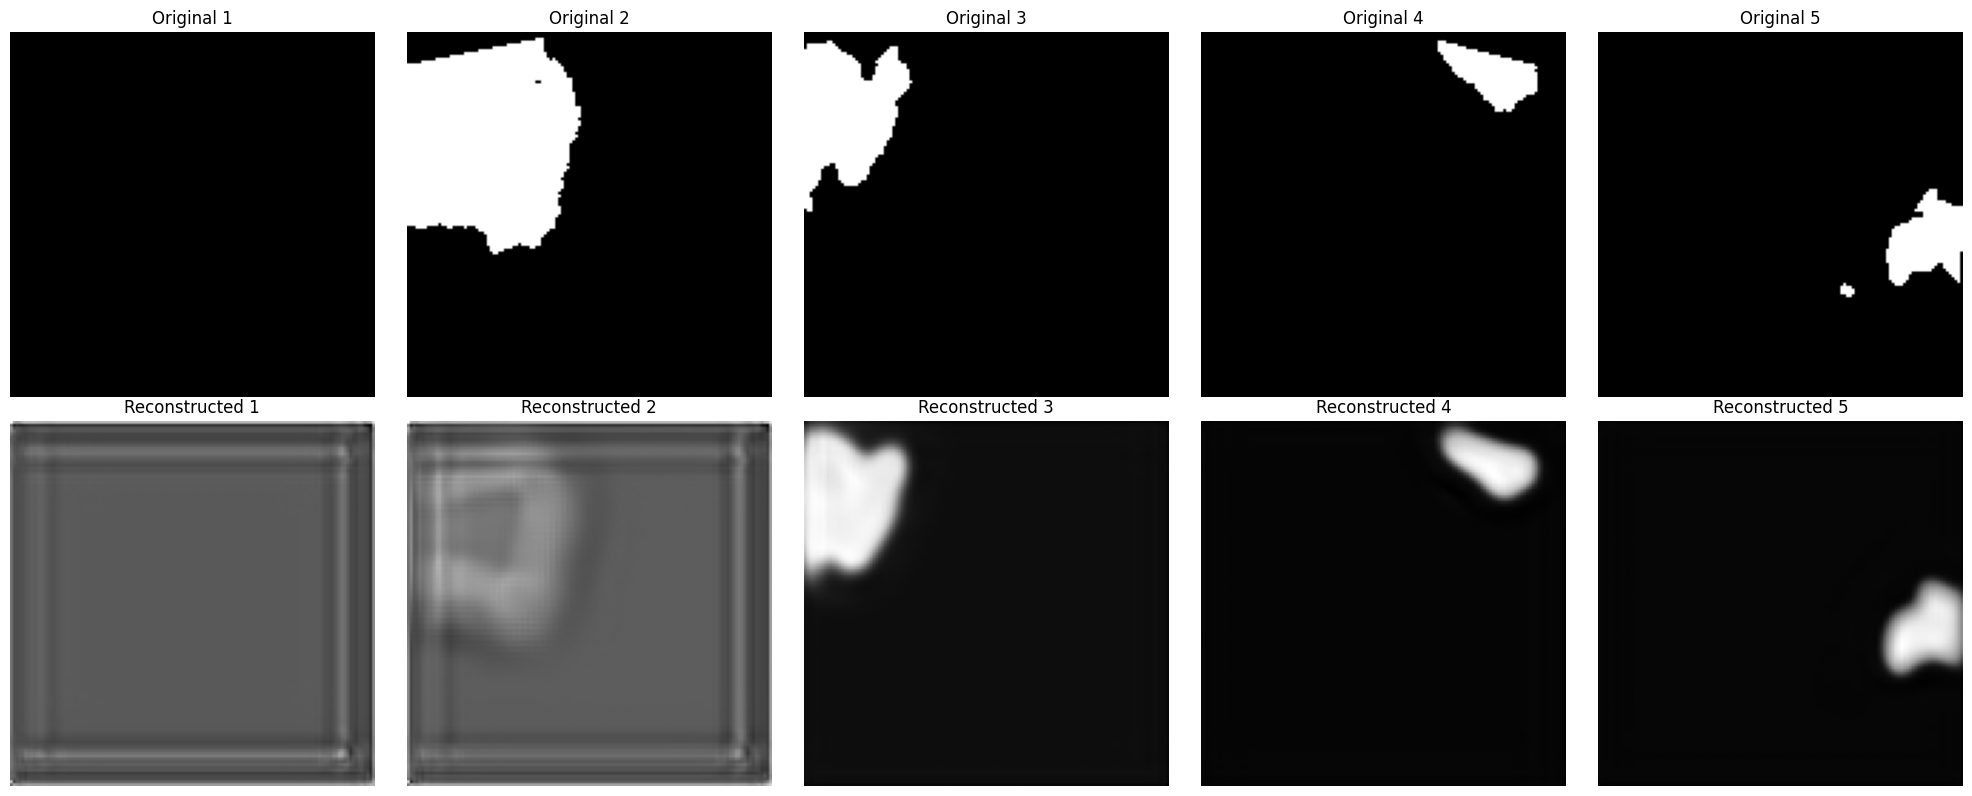

In [174]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure test_batch and test_recon are already defined
# For example:
# test_batch = ...         # Your original images tensor
# test_recon = ...         # Your reconstructed images output (DecoderOutput)

# Inspect the DecoderOutput to find the correct attribute
print("Attributes of test_recon:", dir(test_recon))

# Assuming 'sample' is the correct attribute holding the images
# If it's different, replace 'sample' with the correct attribute name

# Create subplots: 2 rows (Original and Reconstructed) x 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i in range(5):
    # Plot Original Image
    orig_img = test_batch[i].squeeze().cpu().numpy()
    if orig_img.ndim > 2:
        orig_img = orig_img[0]  # Take first channel if multi-channel

    axes[i].imshow(orig_img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Original {i+1}")

    # Plot Reconstructed Image
    try:
        recon_img = test_recon.sample[i].squeeze().detach().cpu().numpy()
    except AttributeError:
        raise AttributeError("The 'DecoderOutput' object does not have a 'sample' attribute. Please check the correct attribute name.")
    
    if recon_img.ndim > 2:
        recon_img = recon_img[0]  # Take first channel if multi-channel

    axes[i + 5].imshow(recon_img, cmap='gray')
    axes[i + 5].axis('off')
    axes[i + 5].set_title(f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()


# Success Trial

In [32]:
from diffusers import AutoencoderKL

# Define the autoencoder model

vae = AutoencoderKL(in_channels=1, out_channels=1, down_block_types=("DownEncoderBlock2D", "DownEncoderBlock2D", ), 
                    up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", ), block_out_channels=(64, 128, )).to(device)

In [33]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
from PIL import Image

# Define the PositivePatchDataset
class PositivePatchDataset(Dataset):
    def __init__(self, patches):
        """
        Args:
            patches (torch.Tensor): Tensor of patches with shape [N, 1, 128, 128]
        """
        self.patches = patches  # Keep patches on CPU
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),  # Ensure tensor is in [0,1]
        ])

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]  # [1,128,128]
        patch_np = (patch.squeeze(0).cpu().numpy() * 255).astype(np.uint8)  # Convert to [0,255] uint8
        patch_pil = Image.fromarray(patch_np, mode='L')  # Convert to PIL Image in grayscale
        patch_transformed = self.transform(patch_pil)  # Apply augmentations
        return patch_transformed  # [1,128,128], float in [0,1]


In [34]:
# Assuming graph_data_dict and positive_nodes_dict are already defined
# and device is set (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Collect positive patches
positive_patches = []

for key, data in graph_data_dict.items():
    positive_nodes = positive_nodes_dict[key].cpu()  # Ensure on CPU
    positive_patches_sample = data.patches[positive_nodes].permute(0, 3, 1, 2)  # [num_positive, 1, 128, 128]
    positive_patches.append(positive_patches_sample)

# Concatenate all positive patches
positive_patches_sample = torch.cat(positive_patches, dim=0)  # [total_positive, 1, 128, 128]

# Create the dataset
positive_dataset = PositivePatchDataset(positive_patches_sample)

# Split into training and validation sets (e.g., 80% train, 20% val)
train_size = int(0.8 * len(positive_dataset))
val_size = len(positive_dataset) - train_size
train_dataset, val_dataset = random_split(positive_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
num_workers = 0  # Set to 0 for notebook environments

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False  # Optimize data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

# Combine into a dictionary for easy access
plaque_loader = {'train': train_loader, 'val': val_loader}


In [35]:
os.chdir("diffusion_project")

FileNotFoundError: [Errno 2] No such file or directory: 'diffusion_project'

In [36]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Use tqdm for notebook
import os

# Define Loss Function and Optimizer
reconstruction_loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(vae.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Optional

# Training Parameters
num_epochs = 60
log_interval = 100      # How often to log training status
save_interval = 5       # How often to save the model
visualize_interval = max(1, num_epochs // 5)  # Visualize every 1/5 of total epochs
warmup_epochs = 40       # Number of epochs to warm-up the KL term

# Create a directory to save models
os.makedirs('vae_checkpoints', exist_ok=True)

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Function to visualize reconstructions
def visualize_reconstructions(model, dataloader, device, epoch, num_images=5):
    model.eval()
    with torch.no_grad():
        data = next(iter(dataloader))  # Retrieve only data
        data = data.to(device)
        latent_dist = model.encode(data).latent_dist  # Obtain latent distribution
        recon_data = model.decode(latent_dist.sample()).sample  # Decode sampled latent vectors

        # Move tensors to CPU and convert to numpy
        data = data.cpu().numpy()
        recon_data = recon_data.cpu().numpy()

    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Original Image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(data[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed Image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon_data[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    
    plt.suptitle(f"Reconstruction at Epoch {epoch}")
    plt.tight_layout()
    plt.show()



Epoch 1/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 1/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [1/60] | Train Loss: 0.1364 | Val Loss: 0.0448


Epoch 2/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 2/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [2/60] | Train Loss: 0.0363 | Val Loss: 0.0299


Epoch 3/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 3/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [3/60] | Train Loss: 0.0287 | Val Loss: 0.0258


Epoch 4/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 4/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [4/60] | Train Loss: 0.0261 | Val Loss: 0.0240


Epoch 5/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 5/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [5/60] | Train Loss: 0.0249 | Val Loss: 0.0233
Saved model checkpoint at vae_checkpoints/vae_epoch_5.pth


Epoch 6/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 6/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [6/60] | Train Loss: 0.0246 | Val Loss: 0.0233


Epoch 7/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 7/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [7/60] | Train Loss: 0.0241 | Val Loss: 0.0228


Epoch 8/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 8/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [8/60] | Train Loss: 0.0240 | Val Loss: 0.0226


Epoch 9/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 9/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [9/60] | Train Loss: 0.0241 | Val Loss: 0.0226


Epoch 10/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 10/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [10/60] | Train Loss: 0.0241 | Val Loss: 0.0226
Saved model checkpoint at vae_checkpoints/vae_epoch_10.pth


Epoch 11/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 11/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [11/60] | Train Loss: 0.0238 | Val Loss: 0.0225


Epoch 12/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 12/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [12/60] | Train Loss: 0.0239 | Val Loss: 0.0226


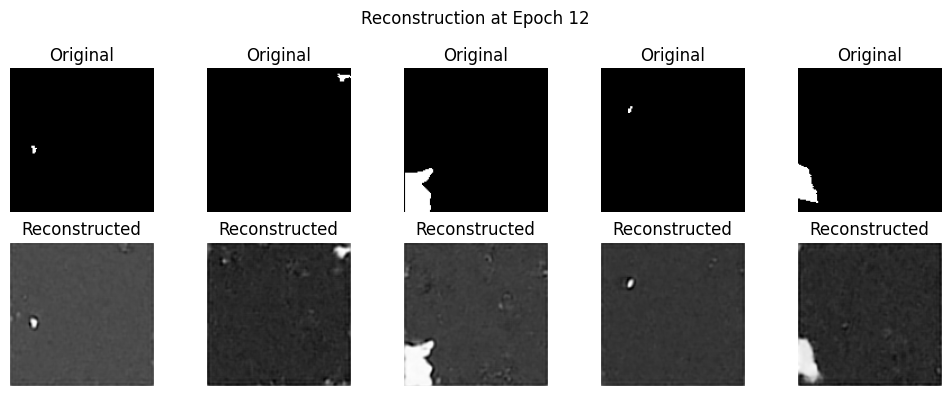

Epoch 13/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 13/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [13/60] | Train Loss: 0.0240 | Val Loss: 0.0229


Epoch 14/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 14/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [14/60] | Train Loss: 0.0241 | Val Loss: 0.0229


Epoch 15/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 15/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [15/60] | Train Loss: 0.0243 | Val Loss: 0.0230
Saved model checkpoint at vae_checkpoints/vae_epoch_15.pth


Epoch 16/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 16/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [16/60] | Train Loss: 0.0244 | Val Loss: 0.0233


Epoch 17/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 17/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [17/60] | Train Loss: 0.0246 | Val Loss: 0.0234


Epoch 18/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 18/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [18/60] | Train Loss: 0.0247 | Val Loss: 0.0235


Epoch 19/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 19/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [19/60] | Train Loss: 0.0248 | Val Loss: 0.0238


Epoch 20/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 20/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [20/60] | Train Loss: 0.0250 | Val Loss: 0.0236
Saved model checkpoint at vae_checkpoints/vae_epoch_20.pth


Epoch 21/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 21/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [21/60] | Train Loss: 0.0249 | Val Loss: 0.0238


Epoch 22/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 22/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [22/60] | Train Loss: 0.0250 | Val Loss: 0.0239


Epoch 23/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 23/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [23/60] | Train Loss: 0.0252 | Val Loss: 0.0240


Epoch 24/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 24/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [24/60] | Train Loss: 0.0253 | Val Loss: 0.0242


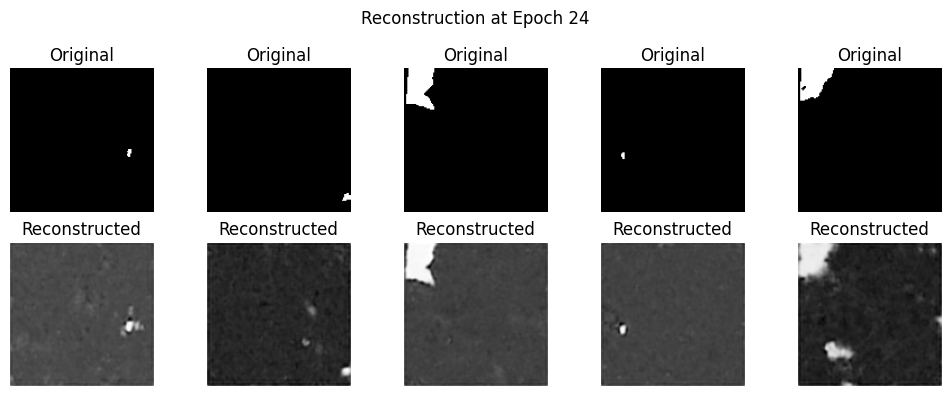

Epoch 25/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 25/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [25/60] | Train Loss: 0.0255 | Val Loss: 0.0244
Saved model checkpoint at vae_checkpoints/vae_epoch_25.pth


Epoch 26/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 26/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [26/60] | Train Loss: 0.0256 | Val Loss: 0.0244


Epoch 27/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 27/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [27/60] | Train Loss: 0.0257 | Val Loss: 0.0246


Epoch 28/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 28/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [28/60] | Train Loss: 0.0258 | Val Loss: 0.0246


Epoch 29/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 29/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [29/60] | Train Loss: 0.0260 | Val Loss: 0.0248


Epoch 30/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 30/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [30/60] | Train Loss: 0.0261 | Val Loss: 0.0248
Saved model checkpoint at vae_checkpoints/vae_epoch_30.pth


Epoch 31/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 31/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [31/60] | Train Loss: 0.0262 | Val Loss: 0.0251


Epoch 32/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 32/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [32/60] | Train Loss: 0.0263 | Val Loss: 0.0251


Epoch 33/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 33/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [33/60] | Train Loss: 0.0265 | Val Loss: 0.0252


Epoch 34/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 34/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [34/60] | Train Loss: 0.0265 | Val Loss: 0.0254


Epoch 35/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 35/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [35/60] | Train Loss: 0.0267 | Val Loss: 0.0254
Saved model checkpoint at vae_checkpoints/vae_epoch_35.pth


Epoch 36/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 36/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [36/60] | Train Loss: 0.0268 | Val Loss: 0.0256


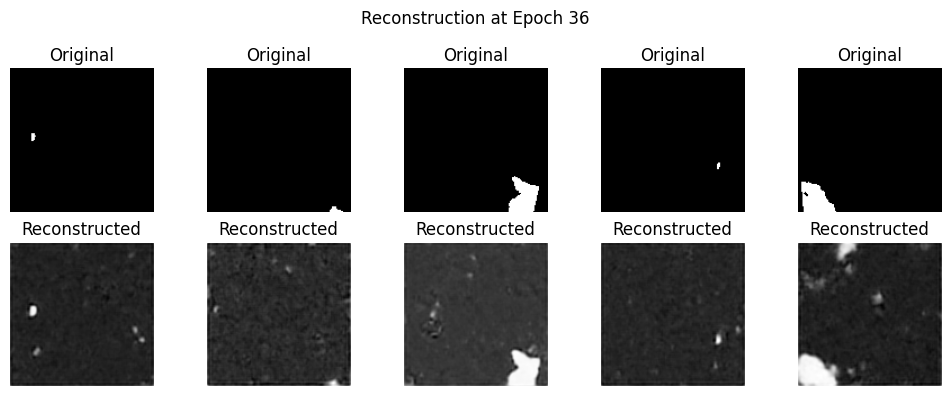

Epoch 37/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 37/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [37/60] | Train Loss: 0.0269 | Val Loss: 0.0256


Epoch 38/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 38/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [38/60] | Train Loss: 0.0270 | Val Loss: 0.0259


Epoch 39/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 39/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [39/60] | Train Loss: 0.0272 | Val Loss: 0.0259


Epoch 40/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 40/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [40/60] | Train Loss: 0.0273 | Val Loss: 0.0259
Saved model checkpoint at vae_checkpoints/vae_epoch_40.pth


Epoch 41/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 41/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [41/60] | Train Loss: 0.0271 | Val Loss: 0.0260


Epoch 42/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 42/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [42/60] | Train Loss: 0.0272 | Val Loss: 0.0260


Epoch 43/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 43/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [43/60] | Train Loss: 0.0272 | Val Loss: 0.0260


Epoch 44/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 44/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [44/60] | Train Loss: 0.0273 | Val Loss: 0.0260


Epoch 45/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 45/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [45/60] | Train Loss: 0.0272 | Val Loss: 0.0262
Saved model checkpoint at vae_checkpoints/vae_epoch_45.pth


Epoch 46/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 46/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [46/60] | Train Loss: 0.0272 | Val Loss: 0.0259


Epoch 47/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 47/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [47/60] | Train Loss: 0.0272 | Val Loss: 0.0259


Epoch 48/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 48/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [48/60] | Train Loss: 0.0272 | Val Loss: 0.0261


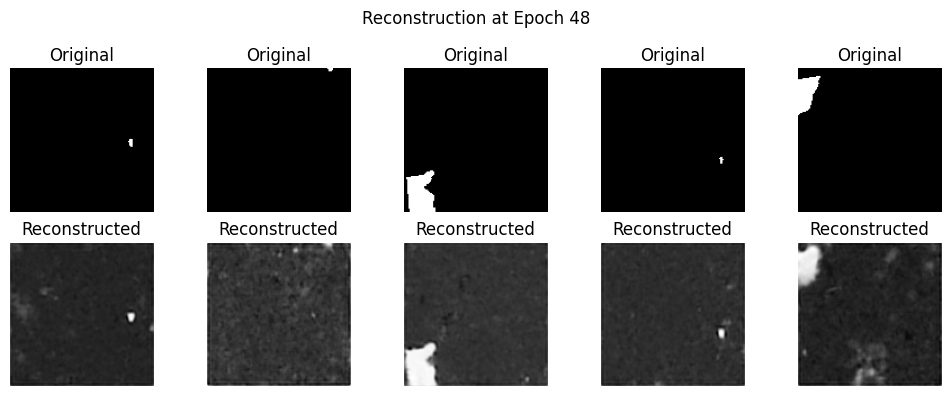

Epoch 49/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 49/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [49/60] | Train Loss: 0.0272 | Val Loss: 0.0259


Epoch 50/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 50/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [50/60] | Train Loss: 0.0272 | Val Loss: 0.0261
Saved model checkpoint at vae_checkpoints/vae_epoch_50.pth


Epoch 51/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 51/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [51/60] | Train Loss: 0.0273 | Val Loss: 0.0262


Epoch 52/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 52/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [52/60] | Train Loss: 0.0272 | Val Loss: 0.0260


Epoch 53/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 53/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [53/60] | Train Loss: 0.0272 | Val Loss: 0.0261


Epoch 54/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 54/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [54/60] | Train Loss: 0.0273 | Val Loss: 0.0259


Epoch 55/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 55/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [55/60] | Train Loss: 0.0272 | Val Loss: 0.0260
Saved model checkpoint at vae_checkpoints/vae_epoch_55.pth


Epoch 56/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 56/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [56/60] | Train Loss: 0.0272 | Val Loss: 0.0260


Epoch 57/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 57/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [57/60] | Train Loss: 0.0273 | Val Loss: 0.0260


Epoch 58/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 58/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [58/60] | Train Loss: 0.0272 | Val Loss: 0.0260


Epoch 59/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 59/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [59/60] | Train Loss: 0.0273 | Val Loss: 0.0260


Epoch 60/60 [Train]:   0%|          | 0/116 [00:00<?, ?it/s]

Epoch 60/60 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch [60/60] | Train Loss: 0.0273 | Val Loss: 0.0261
Saved model checkpoint at vae_checkpoints/vae_epoch_60.pth


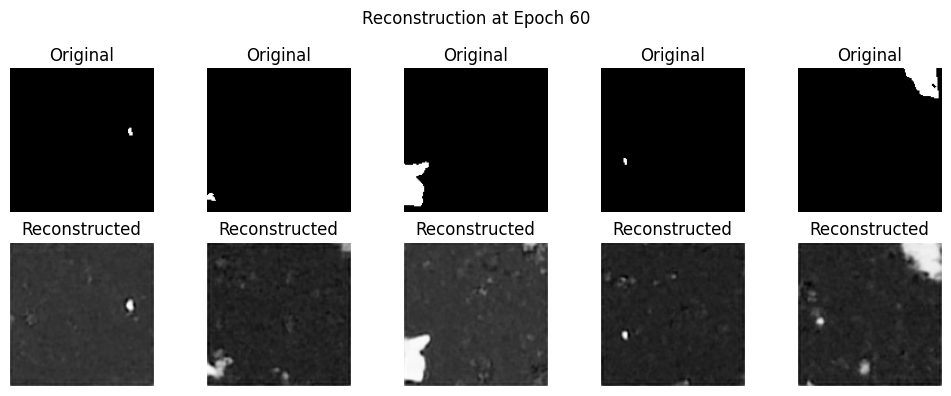

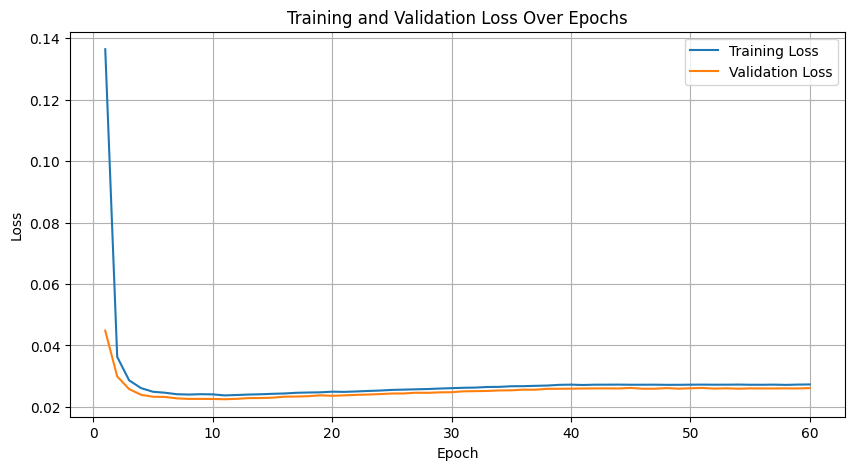

In [37]:
# Training and Validation Loop
for epoch in range(1, num_epochs + 1):
    # Training Phase
    vae.train()
    epoch_train_loss = 0.0
    
    # Initialize tqdm progress bar for training
    train_bar = tqdm(plaque_loader['train'], desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)
    
    for batch_idx, data in enumerate(train_bar):
        data = data.to(device)  # Move data to device
        optimizer.zero_grad()
        
        # Forward pass: Encode and Decode
        latent_dist = vae.encode(data).latent_dist  # Obtain latent distribution
        recon_data = vae.decode(latent_dist.sample()).sample  # Decode sampled latent vectors
        
        # Extract mu and logvar
        mu = latent_dist.mean
        logvar = latent_dist.logvar
        
        # Compute Loss
        recon_loss = reconstruction_loss_fn(recon_data, data)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        # Calculate annealing factor
        annealing_factor = min(1.0, epoch / warmup_epochs)
        loss = recon_loss + kl_loss * annealing_factor
        
        # Backward and Optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)  # Optional: Gradient clipping
        optimizer.step()
        
        # Update training loss
        epoch_train_loss += loss.item()
        
        # Update tqdm progress bar with loss
        train_bar.set_postfix({'Loss': loss.item(), 'Recon': recon_loss.item(), 'KL': kl_loss.item()})
    
    # Calculate average training loss for the epoch
    average_train_loss = epoch_train_loss / len(plaque_loader['train'])
    train_losses.append(average_train_loss)
    
    # Validation Phase
    vae.eval()
    epoch_val_loss = 0.0
    
    with torch.no_grad():
        val_bar = tqdm(plaque_loader['val'], desc=f"Epoch {epoch}/{num_epochs} [Val]", leave=False)
        for data in val_bar:
            data = data.to(device)
            latent_dist = vae.encode(data).latent_dist  # Obtain latent distribution
            recon_data = vae.decode(latent_dist.sample()).sample  # Decode sampled latent vectors
            
            # Extract mu and logvar
            mu = latent_dist.mean
            logvar = latent_dist.logvar
            
            # Compute Loss
            recon_loss = reconstruction_loss_fn(recon_data, data)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss * annealing_factor
            
            # Update validation loss
            epoch_val_loss += loss.item()
            
            # Update tqdm progress bar with loss
            val_bar.set_postfix({'Loss': loss.item(), 'Recon': recon_loss.item(), 'KL': kl_loss.item()})
    
    # Calculate average validation loss for the epoch
    average_val_loss = epoch_val_loss / len(plaque_loader['val'])
    val_losses.append(average_val_loss)
    
    print(f"Epoch [{epoch}/{num_epochs}] | Train Loss: {average_train_loss:.4f} | Val Loss: {average_val_loss:.4f}")
    
    # Step the scheduler
    scheduler.step()
    
    # Save checkpoint periodically
    if epoch % save_interval == 0 or epoch == num_epochs:
        checkpoint_path = f'vae_checkpoints/vae_epoch_{epoch}.pth'
        torch.save(vae.state_dict(), checkpoint_path)
        print(f"Saved model checkpoint at {checkpoint_path}")
    
    # Visualize Reconstructions at specified intervals
    if epoch % visualize_interval == 0 or epoch == num_epochs:
        visualize_reconstructions(vae, plaque_loader['val'], device, epoch, num_images=5)

# Plot Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
# Load the best model
vae.load_state_dict(torch.load('vae_checkpoints/vae_epoch_10.pth'))

/tmp/ipykernel_113761/254462275.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('vae_checkpoints/vae_epoch_10.pth'))


<All keys matched successfully>

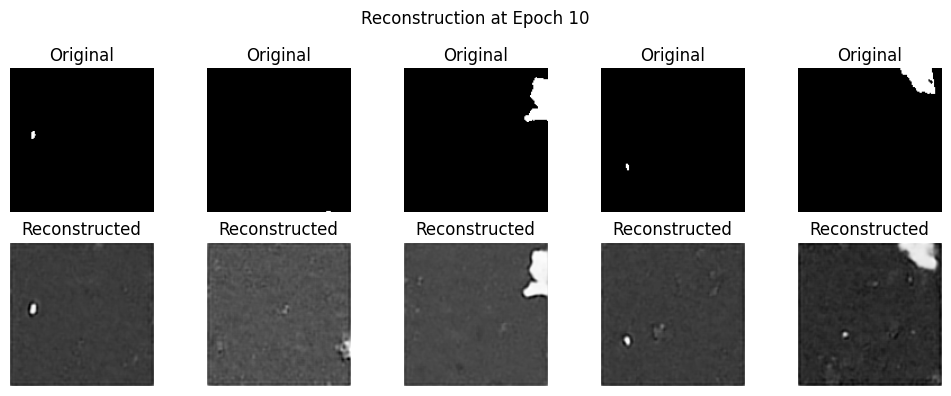

In [42]:
visualize_reconstructions(vae, plaque_loader['val'], device, epoch=10, num_images=5)

# VGAE (Variational Graph Auto-Encoder)

In [132]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_zinb_reconstruction(
    original_counts: torch.Tensor,
    mu: torch.Tensor,
    pi: torch.Tensor,
    alpha: torch.Tensor,
    num_samples: int = 100,
    gene_idx: int = 0,
    title: str = "ZINB Reconstruction"
):
    """
    Visualize reconstruction quality by comparing original counts vs. reconstructed ZINB means.
    Args:
        original_counts (torch.Tensor): Original count matrix, shape (num_nodes, num_genes).
        mu (torch.Tensor): Reconstructed NB means, shape (num_nodes, num_genes).
        pi (torch.Tensor): Zero-inflation probabilities, shape (num_nodes, num_genes).
        alpha (torch.Tensor): Inverse dispersion, shape (num_nodes, num_genes) or (1, num_genes).
        num_samples (int): Number of cells to sample for visualization.
        gene_idx (int): Index of the gene to visualize.
        title (str): Title for the plot.
    """
    # Move to CPU and convert to numpy for plotting
    original_np = original_counts.cpu().numpy()
    mu_np = mu.cpu().numpy()
    pi_np = pi.cpu().numpy()
    alpha_np = alpha.cpu().numpy()

    num_nodes = original_np.shape[0]
    # Randomly sample some cells to visualize
    indices = np.random.choice(num_nodes, size=min(num_samples, num_nodes), replace=False)

    # Extract the gene of interest
    original_gene = original_np[indices, gene_idx]
    mu_gene = mu_np[indices, gene_idx]
    pi_gene = pi_np[indices, gene_idx]
    alpha_gene = alpha_np[indices, gene_idx] if alpha_np.shape[0] == num_nodes else alpha_np[0, gene_idx]

    plt.figure(figsize=(12, 5))

    # ---- Subplot 1: Original vs. Reconstructed Means (scatter) ----
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(indices)), original_gene, color='blue', alpha=0.6, label='Original Counts')
    plt.scatter(range(len(indices)), mu_gene, color='red', alpha=0.6, label='Reconstructed Mean (mu)')
    plt.title(f"{title}\nGene {gene_idx} - Original vs. Mean")
    plt.xlabel("Sampled Cell Index")
    plt.ylabel("Count")
    plt.legend()

    # ---- Subplot 2: Zero-inflation Probabilities (and alpha, optional) ----
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(indices)), pi_gene, color='green', alpha=0.6, label='Zero-inflation (pi)')
    # Optionally show alpha for each cell if you want
    if alpha_gene.ndim == 0:
        # alpha is a scalar
        alpha_str = f"alpha = {alpha_gene:.4f}"
        plt.text(0.5, 0.5, alpha_str, fontsize=12, transform=plt.gca().transAxes)
    else:
        # alpha is cell-specific; let's just plot it
        plt.scatter(range(len(indices)), alpha_gene, color='orange', alpha=0.6, label='Alpha (dispersion)')

    plt.title(f"Gene {gene_idx} - pi & alpha")
    plt.xlabel("Sampled Cell Index")
    plt.ylabel("Value")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
from torch_geometric.nn.models import VGAE
from torch_geometric.utils import negative_sampling

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ---------------------------------------------------
# Encoder with optional skip connections, batch norm
# ---------------------------------------------------
class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, latent_dim, use_gat=False):
        super().__init__()
        self.use_gat = use_gat

        # Layer 1
        if use_gat:
            self.conv1 = GATConv(in_channels, hidden_dim, heads=1, dropout=0.1)
        else:
            self.conv1 = GCNConv(in_channels, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)

        # Layer 2
        if use_gat:
            self.conv2 = GATConv(hidden_dim, hidden_dim, heads=1, dropout=0.1)
        else:
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)

        # Optional skip connection
        self.skip = nn.Linear(in_channels, hidden_dim, bias=False)

        # Mean and log-variance
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.logstd = nn.Linear(hidden_dim, latent_dim)

        # Set up the activation function
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x, edge_index):
        x_skip = self.skip(x)

        # Convolution block 1
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = self.leaky_relu(x1)

        # Convolution block 2
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = x2 + x_skip  # skip connection
        x2 = self.leaky_relu(x2)

        # Mean & logstd
        mu = self.mean(x2)
        logstd = self.logstd(x2)
        return mu, logstd


# ------------------------------------------------------
# ZINB Decoder for feature reconstruction
# ------------------------------------------------------
class ZINBDecoder(nn.Module):
    """
    Decoder that outputs parameters of the ZINB distribution:
      mu, alpha, pi
    """
    def __init__(self, latent_dim, out_channels):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 3 * out_channels)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, z):
        h = self.leaky_relu(self.fc1(z))
        h_out = self.fc2(h)  # (N, 3*out_channels)

        out_ch = h_out.size(1) // 3
        log_mu    = h_out[:, 0*out_ch : 1*out_ch]
        log_alpha = h_out[:, 1*out_ch : 2*out_ch]
        logit_pi  = h_out[:, 2*out_ch : 3*out_ch]

        # In the ZINBDecoder, modify how mu and alpha are computed to prevent overflow:
        mu = torch.exp(torch.clamp(log_mu, min=-10, max=10))
        alpha = torch.exp(torch.clamp(log_alpha, min=-10, max=10))
        pi    = torch.sigmoid(logit_pi)

        return mu, alpha, pi


# ------------------------------------------------------
# VGAE Model Composition
# ------------------------------------------------------
class SOTAVGAE(VGAE):
    """
    Inherits from PyG's VGAE.
    We'll decode adjacency with recon_loss(z, edge_index),
    and decode features with our ZINBDecoder.
    """
    def __init__(self, encoder, decoder):
        super().__init__(encoder)
        self.zinb_decoder = decoder

    def reconstruct_features(self, z):
        mu, alpha, pi = self.zinb_decoder(z)
        if torch.isnan(mu).any() or torch.isnan(alpha).any() or torch.isnan(pi).any():
            print("NaN detected in ZINB parameters")
        return mu, alpha, pi
    
# ------------------------------------------------------
# Zero-Inflated Negative Binomial Loss function
# ------------------------------------------------------
def zero_inflated_negative_binomial_loss(x, mu, alpha, pi, eps=1e-8):
    """
    Exactly as defined earlier. Copied here for completeness.
    """
    x = x.float()
    mu = mu.float()
    alpha = alpha.float()
    pi = pi.float()

    # Ensure that the values are within a safe range
    mu    = torch.clamp(mu, min=eps)  # Ensure no zero value for mu
    alpha = torch.clamp(alpha, min=eps)  # Avoid zero alpha
    pi    = torch.clamp(pi, min=eps, max=1 - eps)  # Avoid zero or one pi

    # NB log prob
    log_nb = (
        torch.lgamma(x + alpha)
        - torch.lgamma(alpha)
        - torch.lgamma(x + 1)
        + alpha * torch.log(alpha / (mu + alpha) + eps)
        + x * torch.log(mu / (mu + alpha) + eps)
    )

    zero_ix = (x < 0.5).float()
    log_prob_zero = torch.log(
        pi + (1.0 - pi) * torch.exp(log_nb) + eps
    ) * zero_ix

    log_prob_non_zero = (
        torch.log((1.0 - pi) + eps) + log_nb
    ) * (1.0 - zero_ix)

    log_prob = log_prob_zero + log_prob_non_zero

    nll = -log_prob.sum()  # sum over all i,j
    return nll / x.numel()  # average

# ------------------------------------------------------
# Training loop (modified for ZINB)
# ------------------------------------------------------
# Optional Gradient Clipping in Training Loop:
def train_multi_graph_vgae(
    model, 
    train_graphs, 
    optimizer,
    total_epochs=100,
    alpha=1.0,
    kl_warmup=20
):
    all_epoch_losses = []
    visualization_interval = max(1, total_epochs // 10)

    epoch_pbar = tqdm(range(1, total_epochs + 1), desc="Training", unit="epoch")
    for epoch in epoch_pbar:
        model.train()
        kl_weight = min(1.0, epoch / kl_warmup)

        epoch_loss = 0.0
        optimizer.zero_grad()

        graph_pbar = tqdm(train_graphs, desc=f"Epoch {epoch}", leave=False, unit="graph")
        for data in graph_pbar:
            z = model.encode(data.x, data.edge_index)

            # Adjacency
            loss_adj = model.recon_loss(z, data.edge_index)

            # ZINB feature reconstruction
            mu, alpha_param, pi = model.reconstruct_features(z)
            loss_feat = zero_inflated_negative_binomial_loss(data.x, mu, alpha_param, pi)

            # KL
            kl_div = model.kl_loss() / data.num_nodes

            # Combined
            recon_weight = 10.0  # Adjust as needed
            loss = loss_adj + alpha * loss_feat * recon_weight + kl_weight * kl_div
            epoch_loss += loss

            graph_pbar.set_postfix({
                'Adj Loss': f"{loss_adj.item():.4f}",
                'Feat(ZINB)': f"{loss_feat.item():.4f}",
                'KL': f"{kl_div.item():.4f}",
            })

        epoch_loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        avg_loss = epoch_loss.item() / len(train_graphs)
        all_epoch_losses.append(avg_loss)
        epoch_pbar.set_postfix({'AvgLoss/Graph': f"{avg_loss:.4f}"})

        # ---- Visualization ----
        if epoch % visualization_interval == 0 or epoch == 1:
            model.eval()
            with torch.no_grad():
                # Pick the first training graph for demonstration
                data_vis = train_graphs[0]
                z_vis = model.encode(data_vis.x, data_vis.edge_index)
                mu_vis, alpha_vis, pi_vis = model.reconstruct_features(z_vis)
                
                # Let's visualize gene index 0 (or another gene of interest)
                visualize_zinb_reconstruction(
                    original_counts=data_vis.x,
                    mu=mu_vis,
                    pi=pi_vis,
                    alpha=alpha_vis,
                    gene_idx=0,
                    title=f"Epoch {epoch} Reconstruction (ZINB)"
                )

    # Plot final training loss curve
    plt.figure(figsize=(8,5))
    plt.plot(range(1, total_epochs+1), all_epoch_losses, label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VGAE Multi-Graph Training Loss (ZINB)")
    plt.legend()
    plt.show()

    return all_epoch_losses

Training:   0%|          | 0/40 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/3 [00:00<?, ?graph/s]

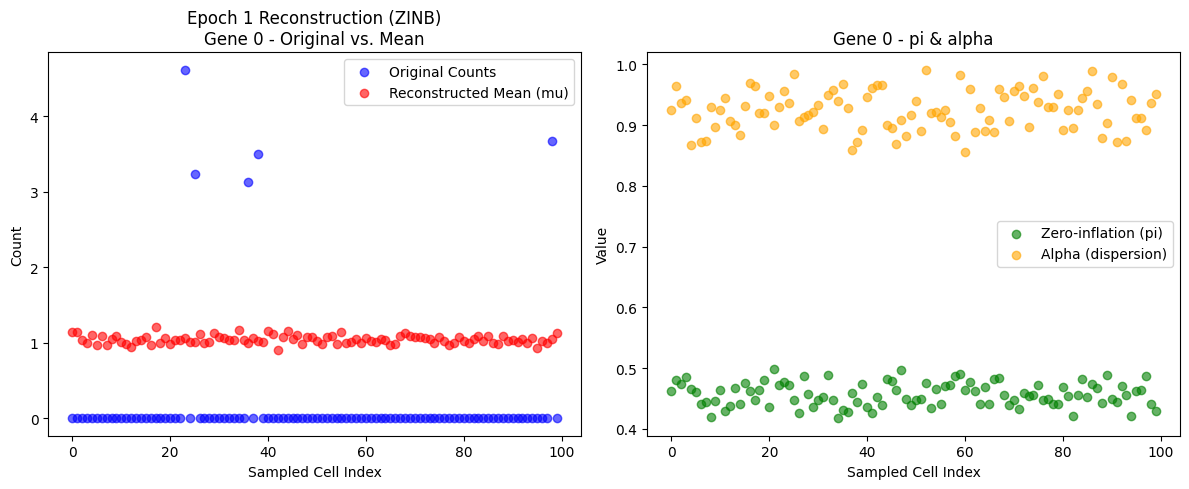

Epoch 2:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 3:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 4:   0%|          | 0/3 [00:00<?, ?graph/s]

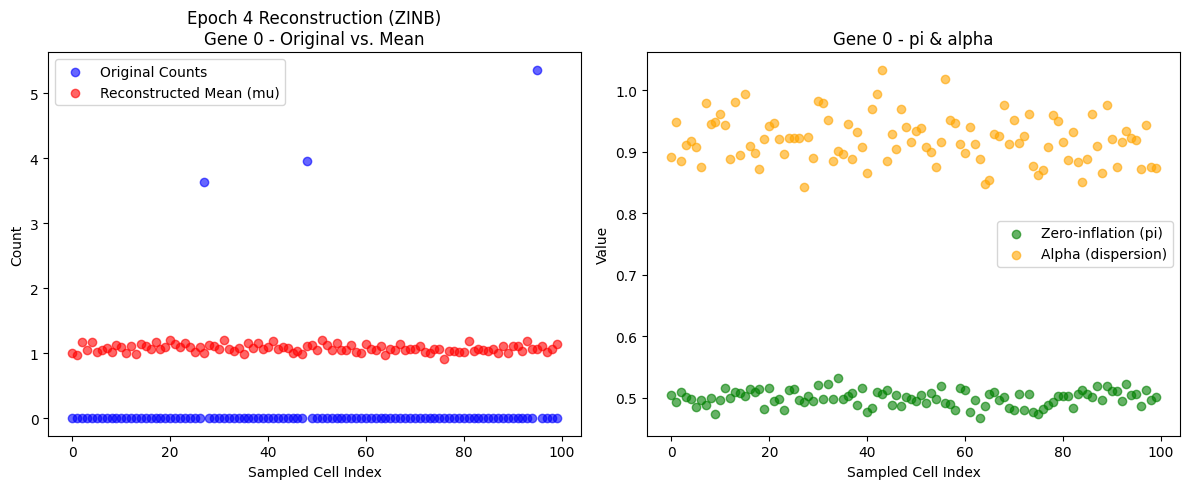

Epoch 5:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 6:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 7:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 8:   0%|          | 0/3 [00:00<?, ?graph/s]

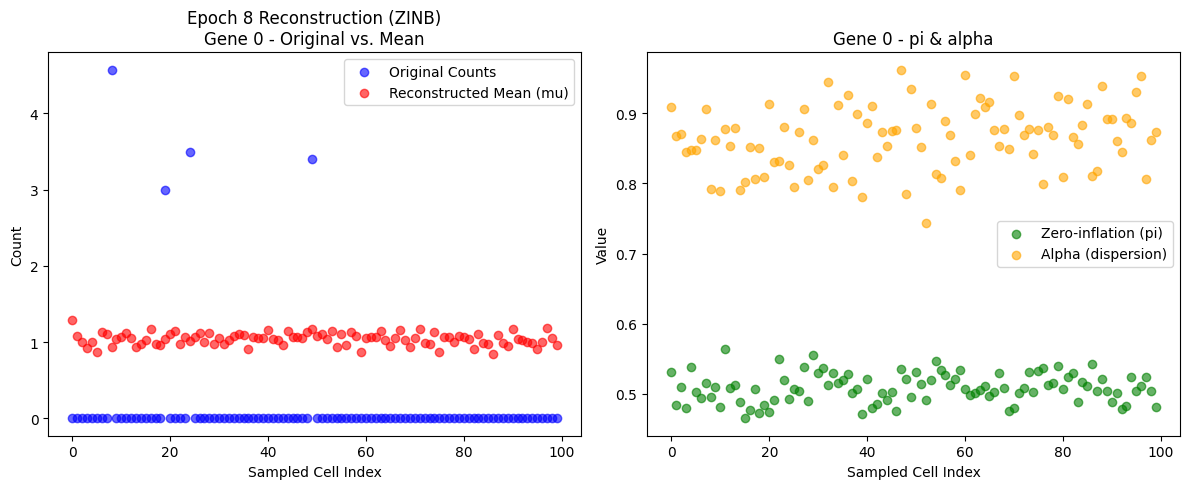

Epoch 9:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 10:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 11:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 12:   0%|          | 0/3 [00:00<?, ?graph/s]

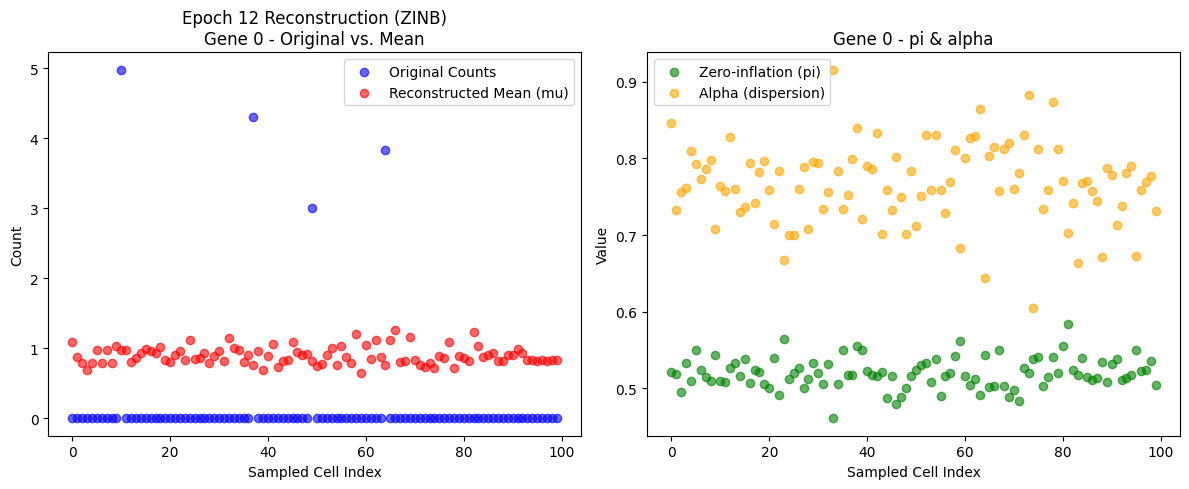

Epoch 13:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 14:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 15:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 16:   0%|          | 0/3 [00:00<?, ?graph/s]

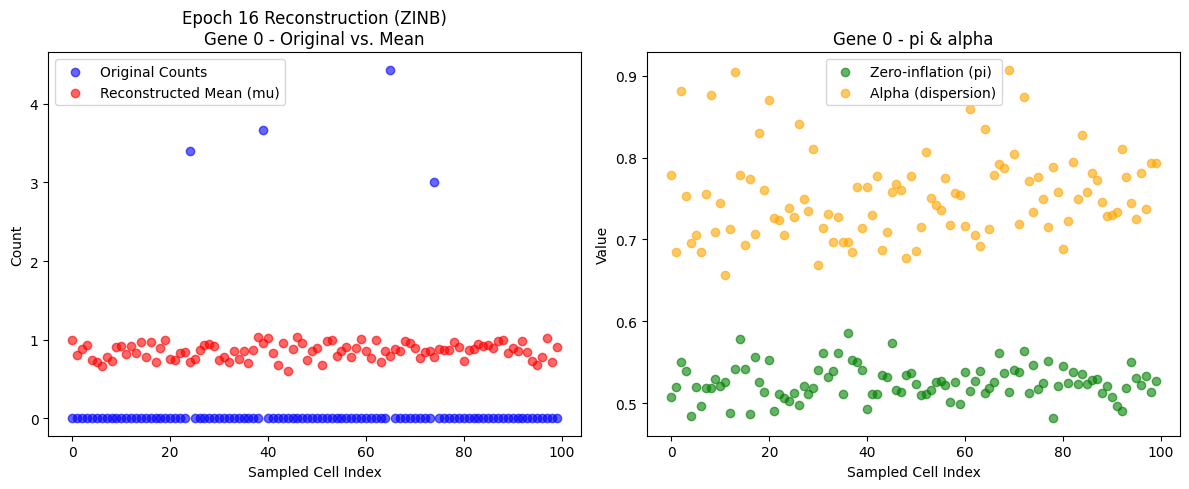

Epoch 17:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 18:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 19:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 20:   0%|          | 0/3 [00:00<?, ?graph/s]

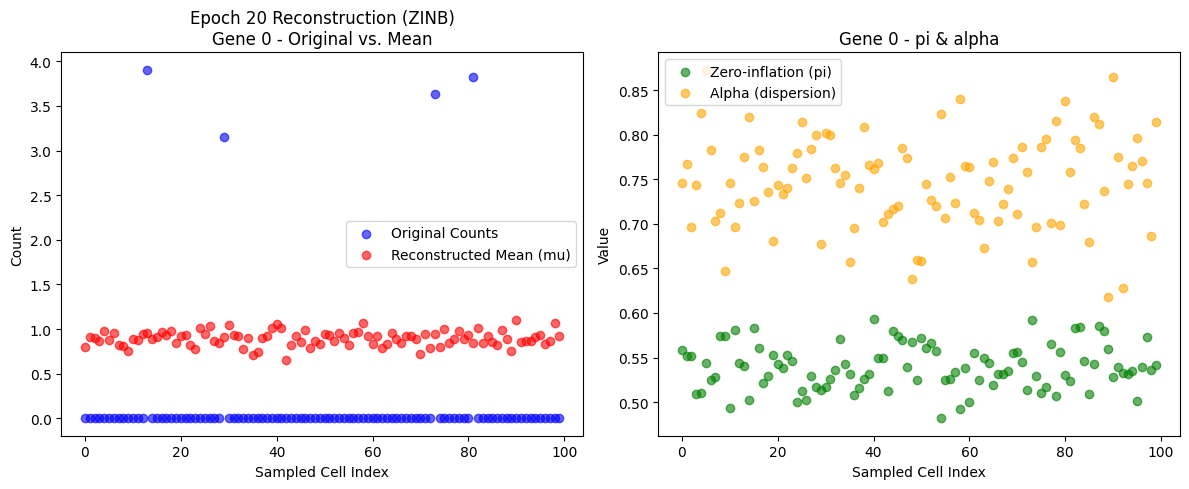

Epoch 21:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 22:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 23:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 24:   0%|          | 0/3 [00:00<?, ?graph/s]

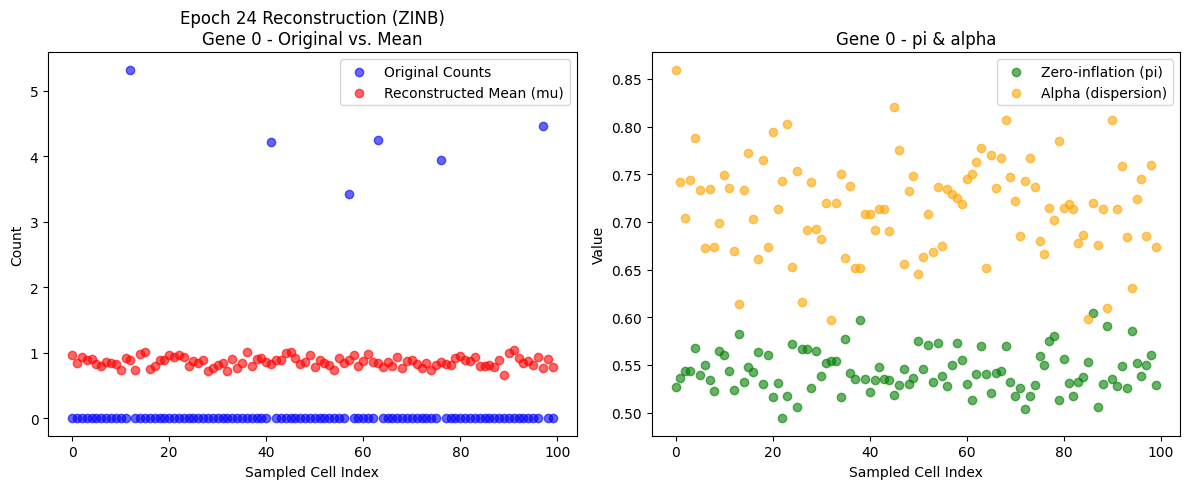

Epoch 25:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 26:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 27:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 28:   0%|          | 0/3 [00:00<?, ?graph/s]

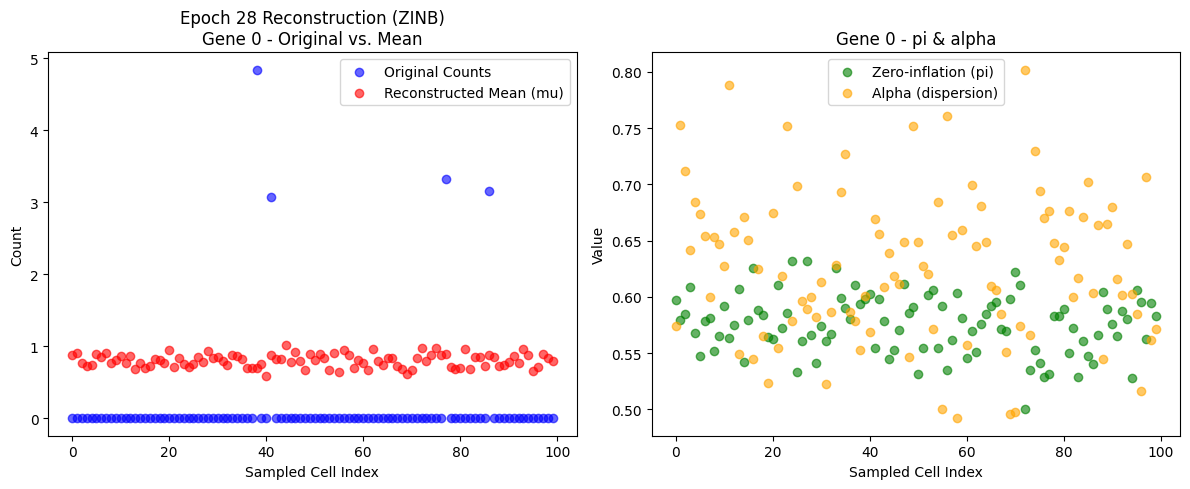

Epoch 29:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 30:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 31:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 32:   0%|          | 0/3 [00:00<?, ?graph/s]

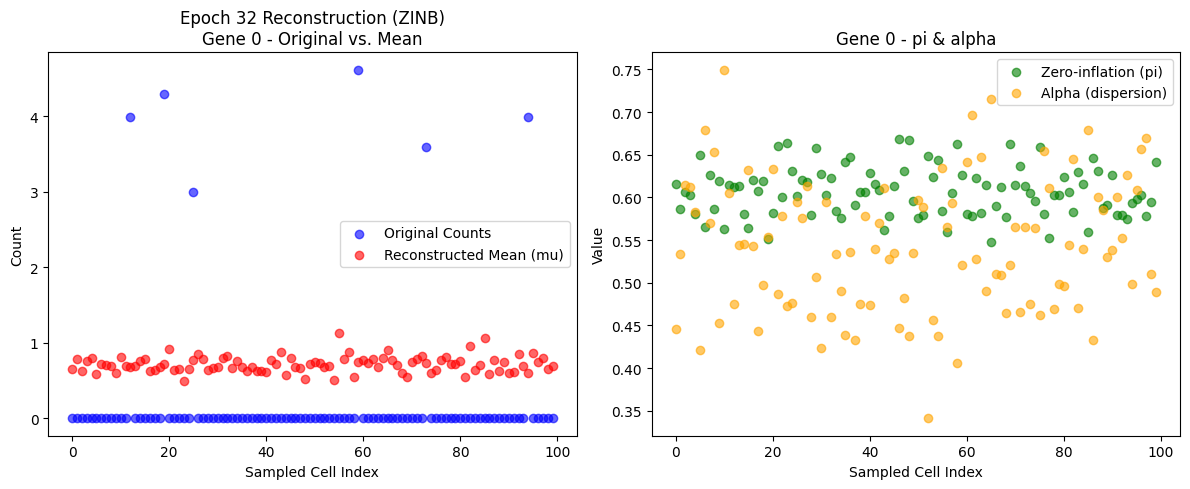

Epoch 33:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 34:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 35:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 36:   0%|          | 0/3 [00:00<?, ?graph/s]

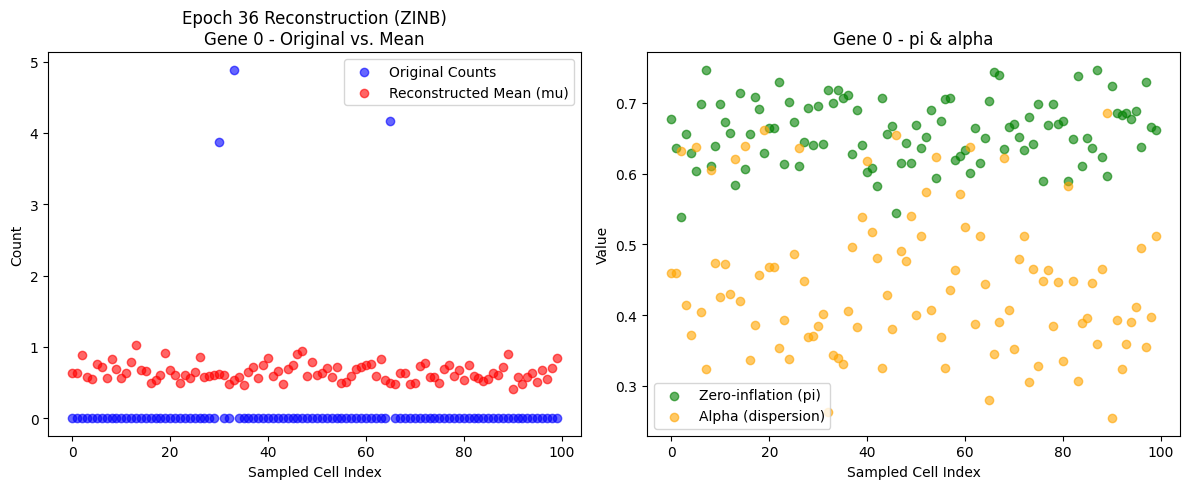

Epoch 37:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 38:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 39:   0%|          | 0/3 [00:00<?, ?graph/s]

Epoch 40:   0%|          | 0/3 [00:00<?, ?graph/s]

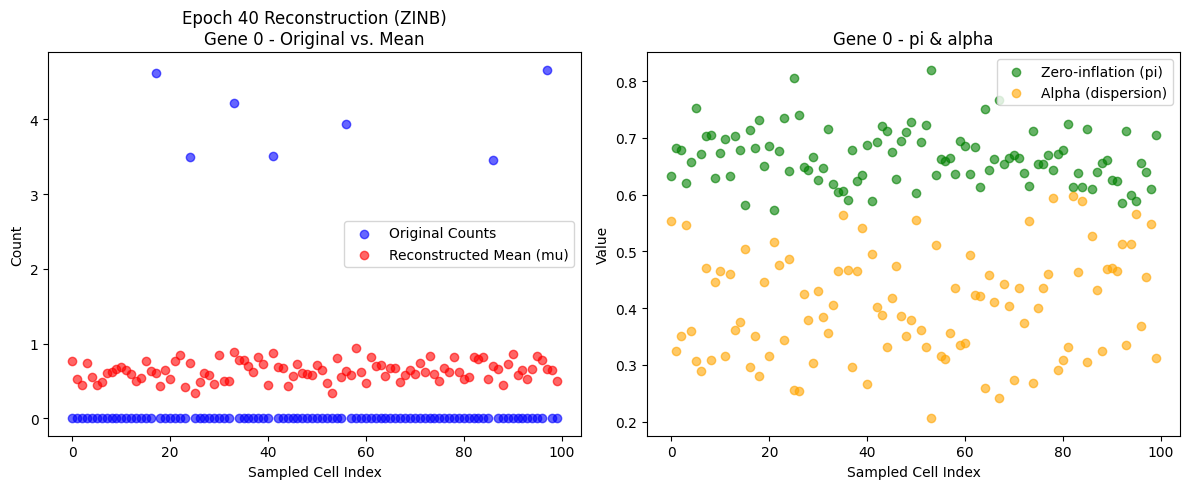

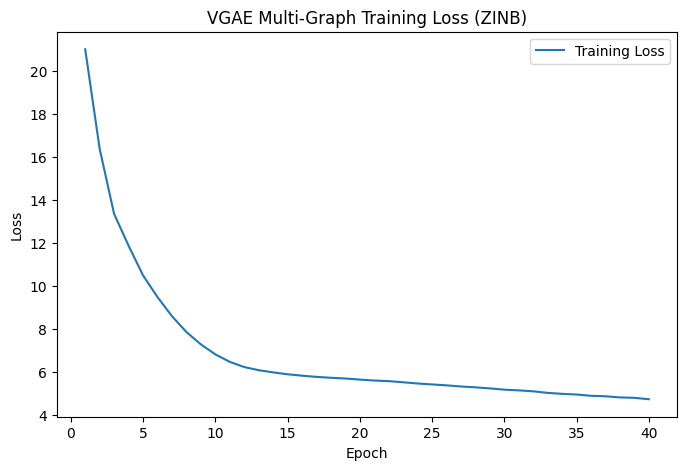

In [136]:
train_graphs = [
    graph_data_dict['8months-disease-replicate_1'],
    graph_data_dict['13months-disease-replicate_1'],
    graph_data_dict['8months-disease-replicate_2']
]
test_graph = graph_data_dict['13months-disease-replicate_2']

some_graph = train_graphs[0]
in_channels = some_graph.x.shape[1]   # e.g. 2766
hidden_dim = 256
latent_dim = 128

encoder = GraphEncoder(in_channels, hidden_dim, latent_dim, use_gat=False)
decoder = ZINBDecoder(latent_dim, out_channels=in_channels)

graph_vae = SOTAVGAE(encoder, decoder)
optimizer = torch.optim.Adam(graph_vae.parameters(), lr=1e-3)

train_losses = train_multi_graph_vgae(
    graph_vae, 
    train_graphs, 
    optimizer,
    total_epochs=40,
    alpha=1.0,     # weight for the ZINB feature loss
    kl_warmup=20
)


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [4.9003, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 4.5118],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])